#Lentic hyperparameter tuning

##Libraries

Cargar paquetes

In [192]:
import pickle
import joblib
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import pandas as pd
import seaborn as sns
import geopandas as gpd
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, matthews_corrcoef, roc_auc_score, jaccard_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##Database download

###Load dataset 2022

In [193]:
# Definir la URL para cargar el archivo Excel que contiene datos sobre contaminantes de aguas lénticas

#lentico_completo = pd.read_excel('/content/lentic_contaminants_2012-2022.xlsx')
url_lentico_completo = "https://raw.githubusercontent.com/Ricardo8932/Paper/main/Database/Lentic/lentic_contaminants_2012-2022_p.xlsx"
url_lentico_sites = "https://raw.githubusercontent.com/Ricardo8932/Paper/main/Database/Lentic/lentic_sites.xlsx"

In [194]:
# Cargar el DataFrame 'lentico' desde un archivo Excel en la URL especificada

lentico_completo = pd.read_excel(url_lentico_completo)
lentico_sites = pd.read_excel(url_lentico_sites)

###Load dataset 2023

In [195]:
# Definir la URL para cargar el archivo Excel que contiene datos sobre contaminantes de aguas lénticas

#url_lentico="https://raw.githubusercontent.com/Ricardo8932/Proyecto_Conagua_Final_Tesis/main/Lentico/al_2023/lentico_contaminantes.xlsx"

In [196]:
# Cargar el DataFrame 'lentico' desde un archivo Excel en la URL especificada

#lentico = pd.read_excel(url_lentico)

##Preprocessing

In [197]:
lentico = lentico_completo.copy()

In [198]:
# Obtener los índices (números de fila) del DataFrame 'lentico' y almacenarlos en la variable 'lentico_row_idx'
lentico_row_idx = lentico.index
lentico_row_idx

RangeIndex(start=0, stop=15427, step=1)

In [199]:
# Obtener los nombres de las columnas del DataFrame 'lentico' y almacenarlos en la variable 'lentico_col_idx'
lentico_col_idx = lentico.columns

# Mostrar los nombres de las columnas del DataFrame 'lentico'
lentico_col_idx


Index(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'AÑO', 'SST', 'CF',
       'E_COLI', 'ODs%', 'ODm%', 'ODf%', 'DBO5', 'DQO', 'TOX_D48s', 'TOX_D48f',
       'TOX_F15s', 'TOX_F15f'],
      dtype='object')

In [200]:
# Mostrar los tipos de datos de cada columna en el DataFrame 'lentico'
lentico.dtypes


,0
CLAVE SITIO,object
CLAVE MONITOREO,object
NOMBRE DEL SITIO,object
TIPO CUERPO DE AGUA,object
FECHA REALIZACIÓN,datetime64[ns]
AÑO,int64
SST,object
CF,object
E_COLI,object
ODs%,object


In [201]:
# Mostrar las primeras 5 filas del DataFrame 'lentico'
lentico.head()

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,AÑO,SST,CF,E_COLI,ODs%,ODm%,ODf%,DBO5,DQO,TOX_D48s,TOX_D48f,TOX_F15s,TOX_F15f
0,DLAGU11,DLAGU11-021212,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2012-12-20,2012,<10,<3,<3,<10,<10,<10,2.34,19.776,<1,<1,<1,<1
1,DLAGU11,DLAGU11-140413,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2013-04-11,2013,<10,<1,<1,NaN,NaN,NaN,12.51,15.2,<1,<1,<1,<1
2,DLAGU11,DLAGU11-201013,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2013-10-17,2013,<10,285,<1,NaN,<10,<10,<2,41.976,<1,<1,<1,<1
3,DLAGU11,DLAGU11-090214,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2014-02-04,2014,<10,1728,86,137.9,61.8,36.5,9,35,<1,<1,<1,<1
4,DLAGU11,DLAGU11-100814,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2014-07-30,2014,<10,160,<1,102.1,37.5,28.7,4.2,44.74,<1,<1,<1,<1


In [202]:
# Contar el número de valores nulos en cada columna del DataFrame 'lentico'
lentico.isnull().sum()

,0
CLAVE SITIO,0
CLAVE MONITOREO,0
NOMBRE DEL SITIO,0
TIPO CUERPO DE AGUA,0
FECHA REALIZACIÓN,0
AÑO,0
SST,252
CF,348
E_COLI,2065
ODs%,2089


In [203]:
# Mostrar un resumen conciso del DataFrame 'lentico'
lentico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15427 entries, 0 to 15426
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          15427 non-null  object        
 1   CLAVE MONITOREO      15427 non-null  object        
 2   NOMBRE DEL SITIO     15427 non-null  object        
 3   TIPO CUERPO DE AGUA  15427 non-null  object        
 4   FECHA REALIZACIÓN    15427 non-null  datetime64[ns]
 5   AÑO                  15427 non-null  int64         
 6   SST                  15175 non-null  object        
 7   CF                   15079 non-null  object        
 8   E_COLI               13362 non-null  object        
 9   ODs%                 13338 non-null  object        
 10  ODm%                 8305 non-null   object        
 11  ODf%                 7746 non-null   object        
 12  DBO5                 13532 non-null  object        
 13  DQO                  13391 non-

In [204]:
# Obtener los nombres de las columnas del DataFrame 'lentico'
columns = lentico.columns.values

# Reemplazar caracteres específicos en todas las columnas del DataFrame
lentico[columns] = lentico[columns].replace({'<':''}, regex=True)  # Eliminar el símbolo '<'
lentico[columns] = lentico[columns].replace({'>':''}, regex=True)  # Eliminar el símbolo '>'
lentico[columns] = lentico[columns].replace({'≤':''}, regex=True)  # Eliminar el símbolo '≤'
lentico[columns] = lentico[columns].replace({'≥':''}, regex=True)  # Eliminar el símbolo '≥'

In [205]:
# Mostrar las primeras 5 filas del DataFrame 'lentico' para verificar si se han eliminado los signos '<, ≤' y '>, ≥'
lentico.head()

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,AÑO,SST,CF,E_COLI,ODs%,ODm%,ODf%,DBO5,DQO,TOX_D48s,TOX_D48f,TOX_F15s,TOX_F15f
0,DLAGU11,DLAGU11-021212,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2012-12-20,2012,10,3,3,10,10,10,2.34,19.776,1,1,1,1
1,DLAGU11,DLAGU11-140413,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2013-04-11,2013,10,1,1,NaN,NaN,NaN,12.51,15.2,1,1,1,1
2,DLAGU11,DLAGU11-201013,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2013-10-17,2013,10,285,1,NaN,10,10,2,41.976,1,1,1,1
3,DLAGU11,DLAGU11-090214,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2014-02-04,2014,10,1728,86,137.9,61.8,36.5,9,35,1,1,1,1
4,DLAGU11,DLAGU11-100814,PRESA JOCOQUI 100M AGUAS ARRIBA DE LA CORTINA,LÉNTICO,2014-07-30,2014,10,160,1,102.1,37.5,28.7,4.2,44.74,1,1,1,1


In [206]:
# Seleccionar las columnas del DataFrame 'lentico' que se desean convertir a tipo numérico (índices del 6 al 17)
columns_to_convert = lentico.columns[6:18]

# Convertir las columnas seleccionadas a tipo numérico; cualquier valor que no pueda ser convertido se convertirá en NaN
lentico[columns_to_convert] = lentico[columns_to_convert].apply(pd.to_numeric, errors='coerce')


In [207]:
# Seleccionar las columnas del DataFrame 'lentico' desde la columna 13 hasta la 24 (excluyendo la 25) usando iloc
selected_columns = lentico.iloc[:, 6:18]

# Mostrar las primeras 10 filas del DataFrame 'selected_columns'
selected_columns.head(10)


,SST,CF,E_COLI,ODs%,ODm%,ODf%,DBO5,DQO,TOX_D48s,TOX_D48f,TOX_F15s,TOX_F15f
0,10.0,3.0,3.0,10.0,10.0,10.0,2.34,19.776,1.0,1.0,1.0,1.0
1,10.0,1.0,1.0,NaN,NaN,NaN,12.51,15.200,1.0,1.0,1.0,1.0
2,10.0,285.0,1.0,NaN,10.0,10.0,2.00,41.976,1.0,1.0,1.0,1.0
3,10.0,1728.0,86.0,137.9,61.8,36.5,9.00,35.000,1.0,1.0,1.0,1.0
4,10.0,160.0,1.0,102.1,37.5,28.7,4.20,44.740,1.0,1.0,1.0,1.0
5,10.0,63.0,1.0,114.6,37.0,37.0,2.00,10.000,1.0,1.0,1.0,1.0
6,10.0,426.0,1.0,115.6,26.4,30.8,4.66,36.790,1.0,1.0,1.0,1.0
7,10.0,148.0,1.0,104.3,66.0,27.1,2.00,10.000,1.0,1.0,1.0,1.0
8,10.0,148.0,1.0,99.4,98.3,99.2,2.00,22.570,1.0,1.0,1.0,1.0
9,10.0,52.0,1.0,114.0,63.3,36.2,4.04,36.810,1.0,1.0,1.0,1.0


In [208]:
# Mostrar información general sobre el DataFrame 'lentico'
lentico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15427 entries, 0 to 15426
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          15427 non-null  object        
 1   CLAVE MONITOREO      15427 non-null  object        
 2   NOMBRE DEL SITIO     15427 non-null  object        
 3   TIPO CUERPO DE AGUA  15427 non-null  object        
 4   FECHA REALIZACIÓN    15427 non-null  datetime64[ns]
 5   AÑO                  15427 non-null  int64         
 6   SST                  15175 non-null  float64       
 7   CF                   15078 non-null  float64       
 8   E_COLI               13362 non-null  float64       
 9   ODs%                 13338 non-null  float64       
 10  ODm%                 8305 non-null   float64       
 11  ODf%                 7746 non-null   float64       
 12  DBO5                 13532 non-null  float64       
 13  DQO                  13384 non-

In [209]:
# Cambiar el tipo de datos de las columnas 'AÑO', 'LATITUD' y 'LONGITUD' a 'object' en el DataFrame 'lentico'
lentico = lentico.astype({'AÑO':'object','FECHA REALIZACIÓN':'object'})

In [210]:
# Obtener estadísticas descriptivas de las columnas numéricas del DataFrame 'lentico'
lentico.describe()

,SST,CF,E_COLI,ODs%,ODm%,ODf%,DBO5,DQO,TOX_D48s,TOX_D48f,TOX_F15s,TOX_F15f
count,15175.000000,1.507800e+04,1.336200e+04,13338.000000,8305.000000,7746.000000,13532.000000,13384.000000,13243.000000,10152.000000,14860.000000,11251.000000
mean,41.045472,5.761521e+03,1.196096e+03,84.723771,68.880623,58.732522,8.388159,47.124951,1.011664,1.003026,1.049001,1.042294
std,141.219870,2.157159e+05,1.573284e+04,30.979843,29.564981,31.206004,18.212042,84.752352,0.358631,0.128795,0.997475,0.733594
min,10.000000,0.000000e+00,1.000000e+00,10.000000,10.000000,1.000000,2.000000,10.000000,1.000000,1.000000,1.000000,1.000000
25%,10.000000,3.000000e+01,3.000000e+00,64.100000,48.100000,32.500000,2.000000,15.000000,1.000000,1.000000,1.000000,1.000000
50%,14.000000,1.870000e+02,2.000000e+01,88.200000,70.900000,57.800000,3.345000,30.042000,1.000000,1.000000,1.000000,1.000000
75%,33.500000,1.500000e+03,9.000000e+01,103.500000,91.600000,85.000000,8.000000,52.000000,1.000000,1.000000,1.000000,1.000000
max,7150.000000,2.400000e+07,1.200000e+06,210.200000,150.000000,208.500000,511.000000,2923.000000,21.320000,12.210000,100.000000,55.248619


In [211]:
# Selecciona las columnas 6 a 17
columnas_especificas = lentico.iloc[:, 6:18]

# Aplica dropna() solo a esas columnas
lentico_preprocesado = lentico.dropna(subset=columnas_especificas.columns)

In [212]:
# Mostrar información resumida sobre el DataFrame 'lentico'
lentico_preprocesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5429 entries, 0 to 15328
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   float

In [213]:
# Guardar el DataFrame 'lentico' en un archivo Excel llamado 'lentico_preprocesado.xlsx'
lentico_preprocesado.to_excel("lentico_preprocesado.xlsx")

##Water quality

###Funciones para las columnas 'calidad_' y 'cumple_'


In [214]:
# Crea un nuevo DataFrame 'data_lentico' asignando valores NaN a las columnas para la calidad del agua y el cumplimiento de cada contaminante
data_lentico = lentico_preprocesado.assign(calidad_SST=np.nan,calidad_CF=np.nan,calidad_E_COLI=np.nan,calidad_ODs=np.nan,calidad_ODm=np.nan,calidad_ODf=np.nan,calidad_DBO5=np.nan,calidad_DQO=np.nan,calidad_TOX_D48s=np.nan,calidad_TOX_D48f=np.nan,calidad_TOX_F15s=np.nan,calidad_TOX_F15f=np.nan,
                                cumple_SST=np.nan,cumple_CF=np.nan,cumple_E_COLI=np.nan,cumple_ODs=np.nan,cumple_ODm=np.nan,cumple_ODf=np.nan, cumple_DBO5=np.nan,cumple_DQO=np.nan,cumple_TOX_D48s=np.nan,cumple_TOX_D48f=np.nan,cumple_TOX_F15s=np.nan,cumple_TOX_F15f=np.nan)

In [215]:
data_lentico.columns

Index(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'AÑO', 'SST', 'CF',
       'E_COLI', 'ODs%', 'ODm%', 'ODf%', 'DBO5', 'DQO', 'TOX_D48s', 'TOX_D48f',
       'TOX_F15s', 'TOX_F15f', 'calidad_SST', 'calidad_CF', 'calidad_E_COLI',
       'calidad_ODs', 'calidad_ODm', 'calidad_ODf', 'calidad_DBO5',
       'calidad_DQO', 'calidad_TOX_D48s', 'calidad_TOX_D48f',
       'calidad_TOX_F15s', 'calidad_TOX_F15f', 'cumple_SST', 'cumple_CF',
       'cumple_E_COLI', 'cumple_ODs', 'cumple_ODm', 'cumple_ODf',
       'cumple_DBO5', 'cumple_DQO', 'cumple_TOX_D48s', 'cumple_TOX_D48f',
       'cumple_TOX_F15s', 'cumple_TOX_F15f'],
      dtype='object')

In [216]:
# Mostrar información general sobre las nuevas columnas agregadas al DataFrame data_lentico
data_lentico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5429 entries, 0 to 15328
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   float

Función para la columna calidad_

In [217]:
#---------------------------calidad_SST---------------------------------------------------------------------------------
col = 'SST'
conditions  = [ data_lentico[col] <= 25, (data_lentico[col] > 25) & (data_lentico[col] <= 75), (data_lentico[col] > 75) & (data_lentico[col] <= 150), (data_lentico[col] > 150) & (data_lentico[col] <= 400), data_lentico[col] > 400 ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_lentico['calidad_SST'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_CF-------------------------------------------------------------------
col = 'CF'
conditions  = [ data_lentico[col] <= 100, (data_lentico[col] > 100) & (data_lentico[col] <= 200), (data_lentico[col] > 200) & (data_lentico[col] <= 1000), (data_lentico[col] > 1000) & (data_lentico[col] <= 10000), data_lentico[col] > 10000 ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_lentico['calidad_CF'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_E_COLI--------------------------------------------------------------------------------
col = 'E_COLI'
conditions  = [ data_lentico[col] <= 126, (data_lentico[col] > 126) & (data_lentico[col] <= 576), (data_lentico[col] > 576) & (data_lentico[col] <= 850), (data_lentico[col] > 850) & (data_lentico[col] <= 1000), data_lentico[col] > 1000 ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_lentico['calidad_E_COLI'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_ODs-------------------------------------------------------------------------
col = 'ODs%'
conditions  = [ (data_lentico[col] > 70) & (data_lentico[col] <= 110),
                (((data_lentico[col] > 50) & (data_lentico[col] <= 70))|((data_lentico[col] > 110)&(data_lentico[col] <= 120))),
                (((data_lentico[col] > 30) & (data_lentico[col] <= 50))|((data_lentico[col] > 120)&(data_lentico[col] <= 130))),
                (((data_lentico[col] > 10) & (data_lentico[col] <= 30))|((data_lentico[col] > 130)&(data_lentico[col] <= 150))),
                ((data_lentico[col] <= 10)|(data_lentico[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_lentico['calidad_ODs'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_ODm-------------------------------------------------------------------------
col = 'ODm%'
conditions  = [ (data_lentico[col] > 70) & (data_lentico[col] <= 110),
                (((data_lentico[col] > 50) & (data_lentico[col] <= 70))|((data_lentico[col] > 110)&(data_lentico[col] <= 120))),
                (((data_lentico[col] > 30) & (data_lentico[col] <= 50))|((data_lentico[col] > 120)&(data_lentico[col] <= 130))),
                (((data_lentico[col] > 10) & (data_lentico[col] <= 30))|((data_lentico[col] > 130)&(data_lentico[col] <= 150))),
                ((data_lentico[col] <= 10)|(data_lentico[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_lentico['calidad_ODm'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_ODf-------------------------------------------------------------------------
col = 'ODf%'
conditions  = [ (data_lentico[col] > 70) & (data_lentico[col] <= 110),
                (((data_lentico[col] > 50) & (data_lentico[col] <= 70))|((data_lentico[col] > 110)&(data_lentico[col] <= 120))),
                (((data_lentico[col] > 30) & (data_lentico[col] <= 50))|((data_lentico[col] > 120)&(data_lentico[col] <= 130))),
                (((data_lentico[col] > 10) & (data_lentico[col] <= 30))|((data_lentico[col] > 130)&(data_lentico[col] <= 150))),
                ((data_lentico[col] <= 10)|(data_lentico[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_lentico['calidad_ODf'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_DBO5-----------------------------------------------------
col = 'DBO5'
conditions  = [ data_lentico[col] <= 3, (data_lentico[col] > 3) & (data_lentico[col] <= 6), (data_lentico[col] > 6) & (data_lentico[col] <= 30),  (data_lentico[col] > 30) & (data_lentico[col] <= 120), data_lentico[col] > 120]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_lentico['calidad_DBO5'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_DQO------------------------------------------------------
col = 'DQO'
conditions  = [ data_lentico[col] <= 10, (data_lentico[col] > 10) & (data_lentico[col] <= 20), (data_lentico[col] > 20) & (data_lentico[col] <= 40), (data_lentico[col] > 40) & (data_lentico[col] <= 200), data_lentico[col] > 200 ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_lentico['calidad_DQO'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_TOX_D48s---------------------------------------------------------------------
col = 'TOX_D48s'
conditions  = [(data_lentico[col] < 1), (data_lentico[col] >= 1) & (data_lentico[col] <= 1.33), (data_lentico[col] > 1.33) & (data_lentico[col] < 5), data_lentico[col] >= 5 ]
choices     = [ 'No tóxico', 'Toxicidad baja', 'Toxicidad moderada', 'Toxicidad alta' ]
data_lentico['calidad_TOX_D48s'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_TOX_D48f---------------------------------------------------------------------
col = 'TOX_D48f'
conditions  = [(data_lentico[col] < 1), (data_lentico[col] >= 1) & (data_lentico[col] <= 1.33), (data_lentico[col] > 1.33) & (data_lentico[col] < 5), data_lentico[col] >= 5 ]
choices     = [ 'No tóxico', 'Toxicidad baja', 'Toxicidad moderada', 'Toxicidad alta' ]
data_lentico['calidad_TOX_D48f'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_TOX_F15s---------------------------------------------------------------------
col = 'TOX_F15s'
conditions  = [(data_lentico[col] < 1), (data_lentico[col] >= 1) & (data_lentico[col] <= 1.33), (data_lentico[col] > 1.33) & (data_lentico[col] < 5), data_lentico[col] >= 5 ]
choices     = [ 'No tóxico', 'Toxicidad baja', 'Toxicidad moderada', 'Toxicidad alta' ]
data_lentico['calidad_TOX_F15s'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_TOX_F15f---------------------------------------------------------------------
col = 'TOX_F15f'
conditions  = [(data_lentico[col] < 1), (data_lentico[col] >= 1) & (data_lentico[col] <= 1.33), (data_lentico[col] > 1.33) & (data_lentico[col] < 5), data_lentico[col] >= 5 ]
choices     = [ 'No tóxico', 'Toxicidad baja', 'Toxicidad moderada', 'Toxicidad alta' ]
data_lentico['calidad_TOX_F15f'] = np.select(conditions, choices, default=np.nan)

In [218]:
data_lentico.iloc[:5, 18:30] #Columnas tipo de calidad_

,calidad_SST,calidad_CF,calidad_E_COLI,calidad_ODs,calidad_ODm,calidad_ODf,calidad_DBO5,calidad_DQO,calidad_TOX_D48s,calidad_TOX_D48f,calidad_TOX_F15s,calidad_TOX_F15f
0,Excelente,Excelente,Excelente,Fuertemente contaminada,Fuertemente contaminada,Fuertemente contaminada,Excelente,Buena calidad,Toxicidad baja,Toxicidad baja,Toxicidad baja,Toxicidad baja
3,Excelente,Contaminada,Excelente,Contaminada,Buena calidad,Aceptable,Aceptable,Aceptable,Toxicidad baja,Toxicidad baja,Toxicidad baja,Toxicidad baja
4,Excelente,Buena calidad,Excelente,Excelente,Aceptable,Contaminada,Buena calidad,Contaminada,Toxicidad baja,Toxicidad baja,Toxicidad baja,Toxicidad baja
5,Excelente,Excelente,Excelente,Buena calidad,Aceptable,Aceptable,Excelente,Excelente,Toxicidad baja,Toxicidad baja,Toxicidad baja,Toxicidad baja
6,Excelente,Aceptable,Excelente,Buena calidad,Contaminada,Aceptable,Buena calidad,Aceptable,Toxicidad baja,Toxicidad baja,Toxicidad baja,Toxicidad baja


In [219]:
data_lentico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5429 entries, 0 to 15328
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   float

Función para la columna cumple_

In [220]:
#---------------------------cumple_SST-----------------------------------------------------
col = 'calidad_SST'
conditions  = [ data_lentico[col] == 'Excelente', data_lentico[col] == 'Buena calidad', data_lentico[col] == 'Aceptable', data_lentico[col] == 'Contaminada', data_lentico[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_lentico['cumple_SST'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_SST'] = data_lentico['cumple_SST'].astype('int32')

#---------------------------cumple_CF-----------------------------------------------------
col = 'calidad_CF'
conditions  = [ data_lentico[col] == 'Excelente', data_lentico[col] == 'Buena calidad', data_lentico[col] == 'Aceptable', data_lentico[col] == 'Contaminada', data_lentico[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_lentico['cumple_CF'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_CF'] = data_lentico['cumple_CF'].astype('int32')

#---------------------------cumple_E_COLI-----------------------------------------------------
col = 'calidad_E_COLI'
conditions  = [ data_lentico[col] == 'Excelente', data_lentico[col] == 'Buena calidad', data_lentico[col] == 'Aceptable', data_lentico[col] == 'Contaminada', data_lentico[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_lentico['cumple_E_COLI'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_E_COLI'] = data_lentico['cumple_E_COLI'].astype('int32')

#---------------------------cumple_ODs-----------------------------------------------------
col = 'calidad_ODs'
conditions  = [ data_lentico[col] == 'Excelente', data_lentico[col] == 'Buena calidad', data_lentico[col] == 'Aceptable', data_lentico[col] == 'Contaminada', data_lentico[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_lentico['cumple_ODs'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_ODs'] = data_lentico['cumple_ODs'].astype('int32')

#---------------------------cumple_ODm-----------------------------------------------------
col = 'calidad_ODm'
conditions  = [ data_lentico[col] == 'Excelente', data_lentico[col] == 'Buena calidad', data_lentico[col] == 'Aceptable', data_lentico[col] == 'Contaminada', data_lentico[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_lentico['cumple_ODm'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_ODm'] = data_lentico['cumple_ODm'].astype('int32')

#---------------------------cumple_ODf-----------------------------------------------------
col = 'calidad_ODf'
conditions  = [ data_lentico[col] == 'Excelente', data_lentico[col] == 'Buena calidad', data_lentico[col] == 'Aceptable', data_lentico[col] == 'Contaminada', data_lentico[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_lentico['cumple_ODf'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_ODf'] = data_lentico['cumple_ODf'].astype('int32')

#---------------------------cumple_DBO5-----------------------------------------------------
col = 'calidad_DBO5'
conditions  = [ data_lentico[col] == 'Excelente', data_lentico[col] == 'Buena calidad', data_lentico[col] == 'Aceptable', data_lentico[col] == 'Contaminada', data_lentico[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_lentico['cumple_DBO5'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_DBO5'] = data_lentico['cumple_DBO5'].astype('int32')

#---------------------------cumple_DQO-----------------------------------------------------
col = 'calidad_DQO'
conditions  = [ data_lentico[col] == 'Excelente', data_lentico[col] == 'Buena calidad', data_lentico[col] == 'Aceptable', data_lentico[col] == 'Contaminada', data_lentico[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_lentico['cumple_DQO'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_DQO'] = data_lentico['cumple_DQO'].astype('int32')

#---------------------------cumple_TOX_D48s-----------------------------------------------------
col = 'calidad_TOX_D48s'
conditions  = [ data_lentico[col] == 'No tóxico', data_lentico[col] == 'Toxicidad baja', data_lentico[col] == 'Toxicidad moderada', data_lentico[col] == 'Toxicidad alta']
choices     = [ 1, 1, 1, 0 ]
data_lentico['cumple_TOX_D48s'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_TOX_D48s'] = data_lentico['cumple_TOX_D48s'].astype('int32')

#---------------------------cumple_TOX_D48f-----------------------------------------------------
col = 'calidad_TOX_D48f'
conditions  = [ data_lentico[col] == 'No tóxico', data_lentico[col] == 'Toxicidad baja', data_lentico[col] == 'Toxicidad moderada', data_lentico[col] == 'Toxicidad alta']
choices     = [ 1, 1, 1, 0 ]
data_lentico['cumple_TOX_D48f'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_TOX_D48f'] = data_lentico['cumple_TOX_D48f'].astype('int32')

#---------------------------cumple_TOX_F15s-----------------------------------------------------
col = 'calidad_TOX_F15s'
conditions  = [ data_lentico[col] == 'No tóxico', data_lentico[col] == 'Toxicidad baja', data_lentico[col] == 'Toxicidad moderada', data_lentico[col] == 'Toxicidad alta']
choices     = [ 1, 1, 1, 0 ]
data_lentico['cumple_TOX_F15s'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_TOX_F15s'] = data_lentico['cumple_TOX_F15s'].astype('int32')

#---------------------------cumple_TOX_F15f-----------------------------------------------------
col = 'calidad_TOX_F15f'
conditions  = [ data_lentico[col] == 'No tóxico', data_lentico[col] == 'Toxicidad baja', data_lentico[col] == 'Toxicidad moderada', data_lentico[col] == 'Toxicidad alta']
choices     = [ 1, 1, 1, 0 ]
data_lentico['cumple_TOX_F15f'] = np.select(conditions, choices, default=np.nan)
data_lentico['cumple_TOX_F15f'] = data_lentico['cumple_TOX_F15f'].astype('int32')

In [221]:
data_lentico.iloc[:5, 30:] #columnas de tipo cumple_

,cumple_SST,cumple_CF,cumple_E_COLI,cumple_ODs,cumple_ODm,cumple_ODf,cumple_DBO5,cumple_DQO,cumple_TOX_D48s,cumple_TOX_D48f,cumple_TOX_F15s,cumple_TOX_F15f
0,1,1,1,0,0,0,1,1,1,1,1,1
3,1,0,1,0,1,1,1,1,1,1,1,1
4,1,1,1,1,1,0,1,0,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,0,1,1,1,1,1,1,1


In [222]:
data_lentico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5429 entries, 0 to 15328
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   float

Asignación de la calidad del agua

In [223]:
conditions  = [(data_lentico['cumple_DBO5'] == 0) | (data_lentico['cumple_DQO'] == 0) | (data_lentico['cumple_TOX_D48s'] == 0) | (data_lentico['cumple_TOX_D48f'] == 0) | (data_lentico['cumple_TOX_F15s'] == 0) | (data_lentico['cumple_TOX_F15f'] == 0),
               (data_lentico['cumple_E_COLI'] == 0) | (data_lentico['cumple_CF'] == 0) | (data_lentico['cumple_SST'] == 0) | (data_lentico['cumple_ODs'] == 0) | (data_lentico['cumple_ODm'] == 0) | (data_lentico['cumple_ODf'] == 0),
               (data_lentico['cumple_DBO5'] == 1) & (data_lentico['cumple_DQO'] == 1) & (data_lentico['cumple_SST'] == 1) & (data_lentico['cumple_CF'] == 1) & (data_lentico['cumple_E_COLI'] == 1) & (data_lentico['cumple_ODs'] == 1) & (data_lentico['cumple_ODm'] == 1) & (data_lentico['cumple_ODf'] == 1) & (data_lentico['cumple_TOX_D48s'] == 1) & (data_lentico['cumple_TOX_D48f'] == 1) & (data_lentico['cumple_TOX_F15s'] == 1) & (data_lentico['cumple_TOX_F15f'] == 1)]
choices     = [2, 1, 0]
data_lentico['Calidad del agua'] = np.select(conditions, choices, default=np.nan)
data_lentico['Calidad del agua'] = data_lentico['Calidad del agua'].astype('int32')

In [224]:
data_lentico.iloc[:5, 30:]

,cumple_SST,cumple_CF,cumple_E_COLI,cumple_ODs,cumple_ODm,cumple_ODf,cumple_DBO5,cumple_DQO,cumple_TOX_D48s,cumple_TOX_D48f,cumple_TOX_F15s,cumple_TOX_F15f,Calidad del agua
0,1,1,1,0,0,0,1,1,1,1,1,1,1
3,1,0,1,0,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,0,1,0,1,1,1,1,2
5,1,1,1,1,1,1,1,1,1,1,1,1,0
6,1,1,1,1,0,1,1,1,1,1,1,1,1


In [225]:
data_lentico.to_excel("lentico_contaminantes_calidad_cumple_calidad_del_agua.xlsx")

In [226]:
df_lentico_calidad_del_agua = data_lentico.iloc[:, list(range(0, 18)) + [42]]
df_lentico_calidad_del_agua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5429 entries, 0 to 15328
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   float

In [227]:
df_lentico_calidad_del_agua.to_excel("lentico_contaminantes_calidad_del_agua.xlsx")

##Separation by years

In [228]:
lentico_sp = lentico_completo.copy()

In [229]:
lentico_p = lentico_preprocesado.copy()

Sin procesar

In [230]:
df_total_sp = pd.DataFrame(lentico_sp)

# Contar datos por año
conteo_por_año = df_total_sp['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2018    2695
2013    2094
2014    1947
2015    1920
2016    1886
2017    1873
2020     779
2019     772
2012     659
2022     476
2021     326
Name: count, dtype: int64


In [231]:
# Obtener el número de registros
numero_de_registros_sp = df_total_sp.shape[0]

print(f"El número total de registros del dataframe es: {numero_de_registros_sp}")

El número total de registros del dataframe es: 15427


Procesado

In [232]:
df_total_p = pd.DataFrame(lentico_p)

# Contar datos por año
conteo_por_año = df_total_p['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2018    1109
2014     943
2015     891
2016     833
2017     810
2019     344
2012     224
2022     126
2013      97
2021      52
Name: count, dtype: int64


In [233]:
# Obtener el número de registros
numero_de_registros_p = df_total_p.shape[0]

print(f"El número total de registros del dataframe es: {numero_de_registros_p}")

El número total de registros del dataframe es: 5429


Calidad del agua

In [234]:
df_lentico_calidad_del_agua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5429 entries, 0 to 15328
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   float

In [235]:
df_total_calidad = pd.DataFrame(df_lentico_calidad_del_agua)

# Contar datos por año
conteo_por_año = df_total_calidad['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2018    1109
2014     943
2015     891
2016     833
2017     810
2019     344
2012     224
2022     126
2013      97
2021      52
Name: count, dtype: int64


###al año 2021

####Calidad del agua

In [236]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_lentico_calidad_del_agua_2021 = df_lentico_calidad_del_agua[(df_lentico_calidad_del_agua['AÑO'] >= 2012) & (df_lentico_calidad_del_agua['AÑO'] <= 2021)]

In [237]:
df_lentico_calidad_del_agua_2021 = df_lentico_calidad_del_agua_2021.iloc[:, 6:21]

####Sin procesar

In [238]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_2012_al_2021_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2021)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2021_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2021 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2021 es: 14951


####Procesado

In [239]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_2012_al_2021_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2021)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2021_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2021 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2021 es: 5303


###al año 2022

####Sin procesar

In [240]:
# Filtrar valores entre 2012 y 2022 (inclusive)
df_2012_al_2022_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2022)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2022_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2022 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2022 es: 15427


Total de registros limpios del periodo 2012-2022

####Procesado

In [241]:
# Filtrar valores entre 2012 y 2022 (inclusive)
df_2012_al_2022_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2022)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2022_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2022 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2022 es: 5429


###al año 2023

####Sin procesar

In [242]:
# Filtrar valores entre 2012 y 2023 (inclusive)
df_2012_al_2023_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2023)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2023_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2023 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2023 es: 15427


####Procesado

In [243]:
# Filtrar valores entre 2012 y 2023 (inclusive)
df_2012_al_2023_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2023)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2023_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2023 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2023 es: 5429


##Exploratory Data Analysis (EDA)

In [244]:
# Imprimir un mensaje que indica que se mostrará el total de datos del periodo 2012-2023
print("Total de datos del periodo 2012 - 2023: ")

# Mostrar las dimensiones del DataFrame 'lentico' (filas y columnas) como una forma de entender el tamaño del conjunto de datos
lentico.shape

Total de datos del periodo 2012 - 2023: 


(15427, 18)

In [245]:
# Suponiendo que tu DataFrame se llama df
conteo_2023 = lentico[lentico['AÑO'] == 2023].shape[0]
print(f"El número de registros con AÑO 2023 es: {conteo_2023}")

El número de registros con AÑO 2023 es: 0


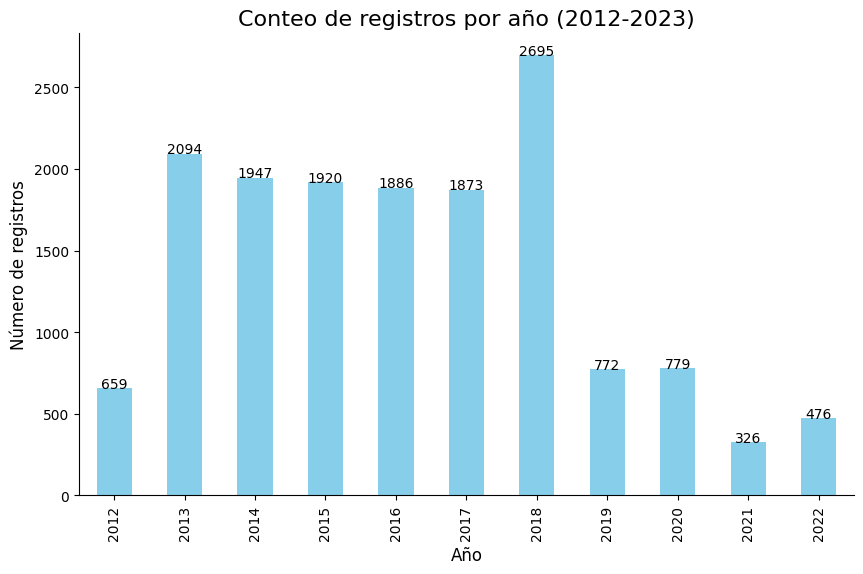

In [246]:
# Agrupar los datos por 'AÑO' y contar cuántos registros hay por cada año
conteo_por_año = lentico['AÑO'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_por_año.plot(kind='bar', color='skyblue')

# Configurar el título y las etiquetas de los ejes
plt.title('Conteo de registros por año (2012-2023)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de registros', fontsize=12)

# Mostrar los valores de las barras encima de cada barra
for index, value in enumerate(conteo_por_año):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=10)

# Ocultar los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar el gráfico
plt.show()


In [247]:
#Codigo para sacar el total de muestras descargadas
#solo del 2012 al 2021, el conjunto de datos es del 2012 al 2023
#por lo tanto se tiene que excluir el año 2022 y el 2023 y crear
#un nuevo dataframe que se llame lentico_2012_2021 y obtendremos
#el total de muestras de ese periodo

In [248]:
#Despues de ese conjunto de datos se crea un dataframe que llamaremos
#lentico_2012_2021 y a ese dataframe hay que aplicarle el
#dropna para que nos de el resultado de total de muestras limpias

###Otras estadisticas

In [249]:
# Agrupar por año y contar los valores de la columna "Water quality" para cada grupo
conteo_por_año = df_lentico_calidad_del_agua.groupby('AÑO')['Calidad del agua'].value_counts().unstack(fill_value=0)

# Definir los nombres de las columnas
nombres_columnas = ['Good', 'Regular', 'Poor']

# Asignar los nombres a las columnas del dataframe
conteo_por_año.columns = nombres_columnas

# Mostrar el resultado
conteo_por_año

,Good,Regular,Poor
AÑO,,,
2012,111,47,66
2013,34,22,41
2014,330,214,399
2015,397,306,188
2016,390,303,140
2017,366,264,180
2018,522,310,277
2019,166,89,89
2021,9,15,28


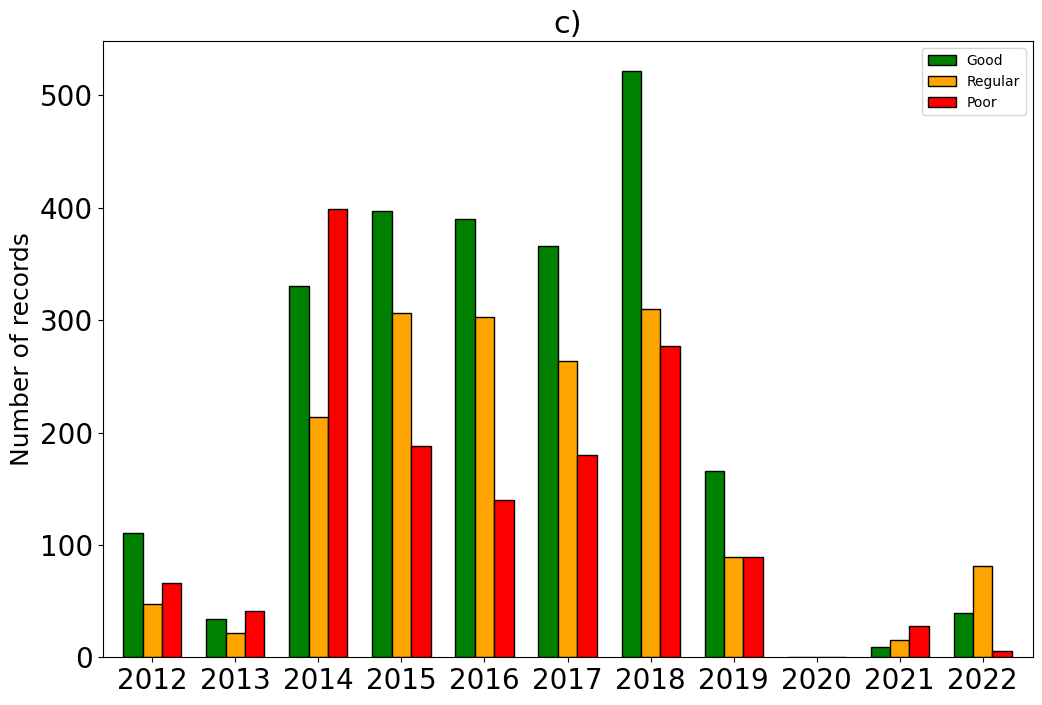

In [250]:
# Crear el DataFrame con tus datos
data = conteo_por_año  # Esto asume que ya tienes los datos de conteo_por_año
index = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]  # Los años disponibles
df = pd.DataFrame(data, index=index)

# Definir una lista de colores para cada categoría
colores = {
    'Good': 'green',
    'Regular': 'orange',
    'Poor': 'red'
}

# Graficar
df.plot(kind='bar', figsize=(12, 8), color=[colores[categoria] for categoria in df.columns], edgecolor='black', width=0.7)

# Configuración de etiquetas y título
plt.title('c)', fontsize=22)  # Título
plt.xlabel('', fontsize=20)  # Etiqueta del eje X
plt.ylabel('Number of records', fontsize=18)  # Etiqueta del eje Y

# Ajustar el tamaño de las etiquetas del eje X e Y
plt.xticks(rotation=0, fontsize=20)  # Etiquetas del eje X
plt.yticks(fontsize=20)  # Etiquetas del eje Y

# Mostrar el gráfico
plt.show()


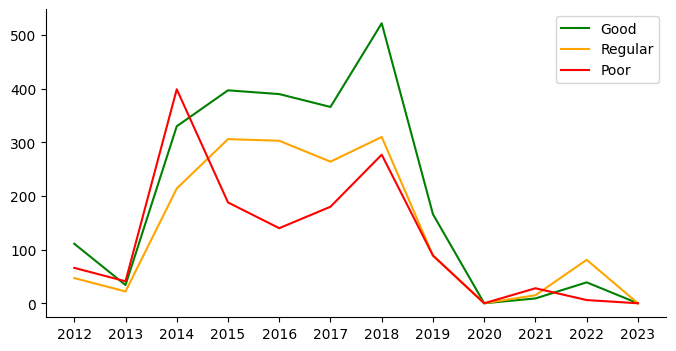

In [251]:
# Crear un rango de años de 2012 a 2023
rango_anos = pd.Index(range(2012, 2024))

# Asegurarse de que todos los años estén presentes, incluso si faltan datos
conteo_por_año = conteo_por_año.reindex(rango_anos, fill_value=0)

# Trazar las tres líneas en la misma figura
plt.figure(figsize=(8, 4))

# Colores: Verde para 'Buena', Naranja para 'Regular', Rojo para 'Mala'
conteo_por_año['Good'].plot(kind='line', color='green', label='Good')
conteo_por_año['Regular'].plot(kind='line', color='orange', label='Regular')
conteo_por_año['Poor'].plot(kind='line', color='red', label='Poor')

# Configurar el título y etiquetas de los ejes
plt.title('')
plt.xlabel('')
plt.ylabel('')

# Asegurarse de que los años del 2012 al 2023 aparezcan en el eje x
plt.xticks(rotation=0, fontsize=10, ticks=range(2012, 2024), labels=range(2012, 2024))

# Ocultar los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [252]:
conteo_por_año = conteo_por_año.T

In [253]:
# Obtener el número de valores de la clase Good para el año seleccionado
año = 2015
registros_good = conteo_por_año.loc['Good', año]
print(f"Número de valores de la clase Good en el año {año}:", registros_good)

Número de valores de la clase Good en el año 2015: 397


In [254]:
# Obtener el número de valores de la clase Regular para el año seleccionado
año = 2015
registros_regular = conteo_por_año.loc['Regular', año]
print(f"Número de valores de la clase Regular en el año {año}:", registros_regular)

Número de valores de la clase Regular en el año 2015: 306


In [255]:
# Obtener el número de valores de la clase Good para el año seleccionado
año = 2015
registros_poor = conteo_por_año.loc['Poor', año]
print(f"Número de valores de la clase Poor en el año {año}:", registros_poor)

Número de valores de la clase Poor en el año 2015: 188


##Statistical Analysis of Lentic Body

###Union de dataframes

In [256]:
# Unir los DataFrames a través de la columna "CLAVE SITIO"
lentico_contaminants_combined = pd.merge(
    lentico_preprocesado,  # DataFrame principal
    lentico_sites[['CLAVE SITIO', 'ORGANISMO CUENCA']],  # Seleccionar solo las columnas necesarias del otro DataFrame
    on='CLAVE SITIO',  # Columna común para realizar la unión
    how='left'  # Tipo de unión: 'left' conserva todos los registros del DataFrame principal
)

# Mostrar el DataFrame resultante
#print(lentico_contaminants_combined)


In [257]:
lentico_contaminants_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   f

In [258]:
# Filtrar valores entre 2012 y 2022 (inclusive)
lentico_contaminants_combined_2022 = lentico_contaminants_combined[(lentico_contaminants_combined['AÑO'] >= 2012) & (lentico_contaminants_combined['AÑO'] <= 2022)]

In [259]:
lentico_contaminants_combined_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   f

###No cumplimiento

####Porcentaje de no cumplimiento por contaminante y cuenca

In [260]:
df2 = lentico_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits2 = {
    'SST': lambda x: x > 150,
    'CF': lambda x: x > 1000,
    'E_COLI': lambda x: x > 850,
    'ODs%': lambda x: x <= 30 or x > 130,
    'ODm%': lambda x: x <= 30 or x > 130,
    'ODf%': lambda x: x <= 30 or x > 130,
    'DBO5': lambda x: x > 30,
    'DQO': lambda x: x > 40,
    'TOX_D48s': lambda x: x >= 5,
    'TOX_D48f': lambda x: x >= 5,
    'TOX_F15s': lambda x: x >= 5,
    'TOX_F15f': lambda x: x >= 5
}

# Crear una columna de no cumplimiento para cada parámetro
for col, condition in limits2.items():
    df2[f'{col}_no_cumple'] = df2[col].apply(condition)

# Calcular el porcentaje de no cumplimiento por parámetro para cada cuenca
non_compliance_summary = pd.DataFrame()
for col in limits2.keys():
    non_compliance_summary[col] = df2.groupby('ORGANISMO CUENCA')[f'{col}_no_cumple'].mean() * 100

# Mostrar el DataFrame con los resultados de no cumplimiento
non_compliance_summary.to_excel('porcentaje_lentico_no_cumplimiento_limites.xlsx')


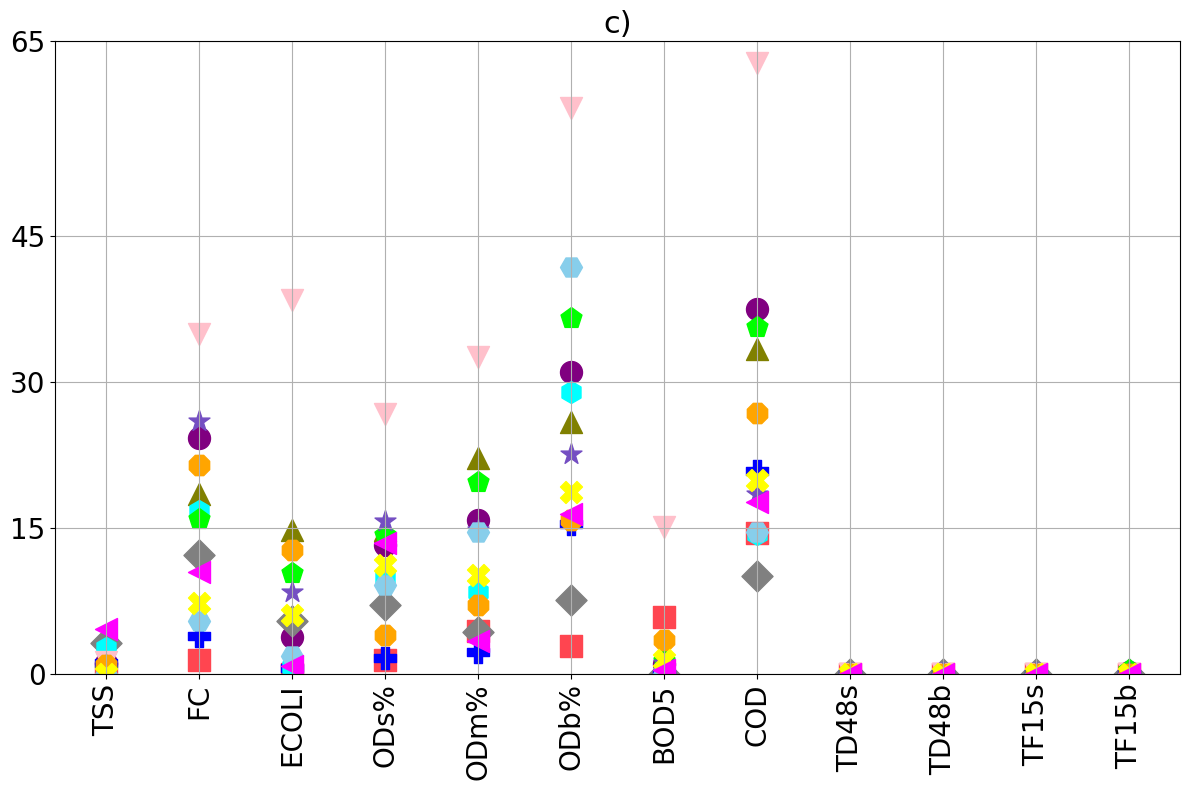

In [261]:
df2 = lentico_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits2 = {
    'SST': lambda x: x <= 150,
    'CF': lambda x: x <= 1000,
    'E_COLI': lambda x: x <= 850,
    'ODs%': lambda x: 30 < x <= 130,
    'ODm%': lambda x: 30 < x <= 130,
    'ODf%': lambda x: 30 < x <= 130,
    'DBO5': lambda x: x <= 30,
    'DQO': lambda x: x <= 40,
    'TOX_D48s': lambda x: x < 5,
    'TOX_D48f': lambda x: x < 5,
    'TOX_F15s': lambda x: x < 5,
    'TOX_F15f': lambda x: x < 5
}

# Crear columnas de cumplimiento para cada parámetro
for col, condition in limits2.items():
    df2[f'{col}_compliance'] = df2[col].apply(condition)

# Calcular el porcentaje de cumplimiento por parámetro para cada cuenca
compliance_summary2 = pd.DataFrame()
for col in limits2.keys():
    compliance_summary2[col] = df2.groupby('ORGANISMO CUENCA')[f'{col}_compliance'].mean() * 100

# Diccionario para renombrar las columnas en el gráfico
column_names_mapping2 = {
    'SST': 'TSS',
    'CF': 'FC',
    'E_COLI': 'ECOLI',
    'ODs%': 'ODs%',
    'ODm%': 'ODm%',
    'ODf%': 'ODb%',
    'DBO5': 'BOD5',
    'DQO': 'COD',
    'TOX_D48s': 'TD48s',
    'TOX_D48f': 'TD48b',
    'TOX_F15s': 'TF15s',
    'TOX_F15f': 'TF15b'
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Colores y marcadores para cada cuenca
cuencas2 = {
    'LERMA SANTIAGO PACÍFICO': ('#800080', 'o'),
    'PENÍNSULA DE BAJA CALIFORNIA': ('#FF4550', 's'),
    'PENÍNSULA DE YUCATÁN': ('#808000', '^'),
    'RÍO BRAVO': ('#808080', 'D'),
    'CUENCAS CENTRALES DEL NORTE': ('#0000FF', 'P'),
    'PACÍFICO NORTE': ('#00FFFF', 'h'),
    'AGUAS DEL VALLE DE MÉXICO': ('#FFC0CB', 'v'),
    'BALSAS': ('#00FF00', 'p'),
    'GOLFO NORTE': ('#744EC2', '*'),
    'PACÍFICO SUR': ('#87CEEB', 'H'),
    'GOLFO CENTRO': ('#FFA500', '8'),
    'FRONTERA SUR': ('#FFFF00', 'X'),
    'NOROESTE': ('#FF00FF', '<'),
}

# Graficar puntos para cada cuenca y parámetro
for cuenca in cuencas2:
    for j, col in enumerate(limits2.keys()):
        color, marker = cuencas2.get(cuenca, ('gray', 'o'))
        ax.scatter(
            [column_names_mapping2[col]],  # Usar los nombres mapeados
            [100 - compliance_summary2.loc[cuenca, col]],
            marker=marker,
            color=color,
            label=f'{cuenca}' if j == 0 else "",
            s=250
        )

# Configuración del eje Y
ax.set_ylim(0, 45)
ax.set_yticks([0, 15, 30, 45, 65])
ax.set_ylabel('', fontsize=20)
ax.tick_params(axis='y', labelsize=20)

# Configuración del eje X
ax.set_xlabel('', fontsize=14, fontweight='bold')
ax.set_xticks(list(column_names_mapping2.values()))  # Mostrar los nombres mapeados
ax.set_xticklabels(list(column_names_mapping2.values()), fontsize=20, rotation=90)
ax.tick_params(axis='x', labelsize=20)  # Tamaño de fuente del eje X

# Título del gráfico
ax.set_title('c)', fontsize=22)

# Ajustar la leyenda para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# (Descomentar si deseas incluir una leyenda)
# ax.legend(
#     by_label.values(),
#     by_label.keys(),
#     title='Cuencas',
#     title_fontsize=14,
#     fontsize=12,
#     loc='upper center',
#     bbox_to_anchor=(0.5, -0.1),
#     ncol=5
# )

# Agregar cuadrícula y mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

####Número total de registros de no cumplimiento por contaminante y cuenca

In [262]:
df1 = lentico_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda para identificar los valores que no cumplen
limits1 = {
    'SST': lambda x: x > 150,
    'CF': lambda x: x > 1000,
    'E_COLI': lambda x: x > 850,
    'ODs%': lambda x: x <= 30 or x > 130,
    'ODm%': lambda x: x <= 30 or x > 130,
    'ODf%': lambda x: x <= 30 or x > 130,
    'DBO5': lambda x: x > 30,
    'DQO': lambda x: x > 40,
    'TOX_D48s': lambda x: x >= 5,
    'TOX_D48f': lambda x: x >= 5,
    'TOX_F15s': lambda x: x >= 5,
    'TOX_F15f': lambda x: x >= 5
}

# Crear una columna de no cumplimiento para cada parámetro
for col, condition in limits1.items():
    df1[f'{col}_no_cumple'] = df1[col].apply(condition)

# Calcular el número total de no cumplimiento por parámetro para cada cuenca
non_compliance_summary1 = pd.DataFrame()
for col in limits1.keys():
    non_compliance_summary1[col] = df1.groupby('ORGANISMO CUENCA')[f'{col}_no_cumple'].sum()

# Mostrar el DataFrame con los resultados de no cumplimiento
#print(non_compliance_summary1)
non_compliance_summary1.to_excel('total_lentico_no_cumplimiento_limites.xlsx')

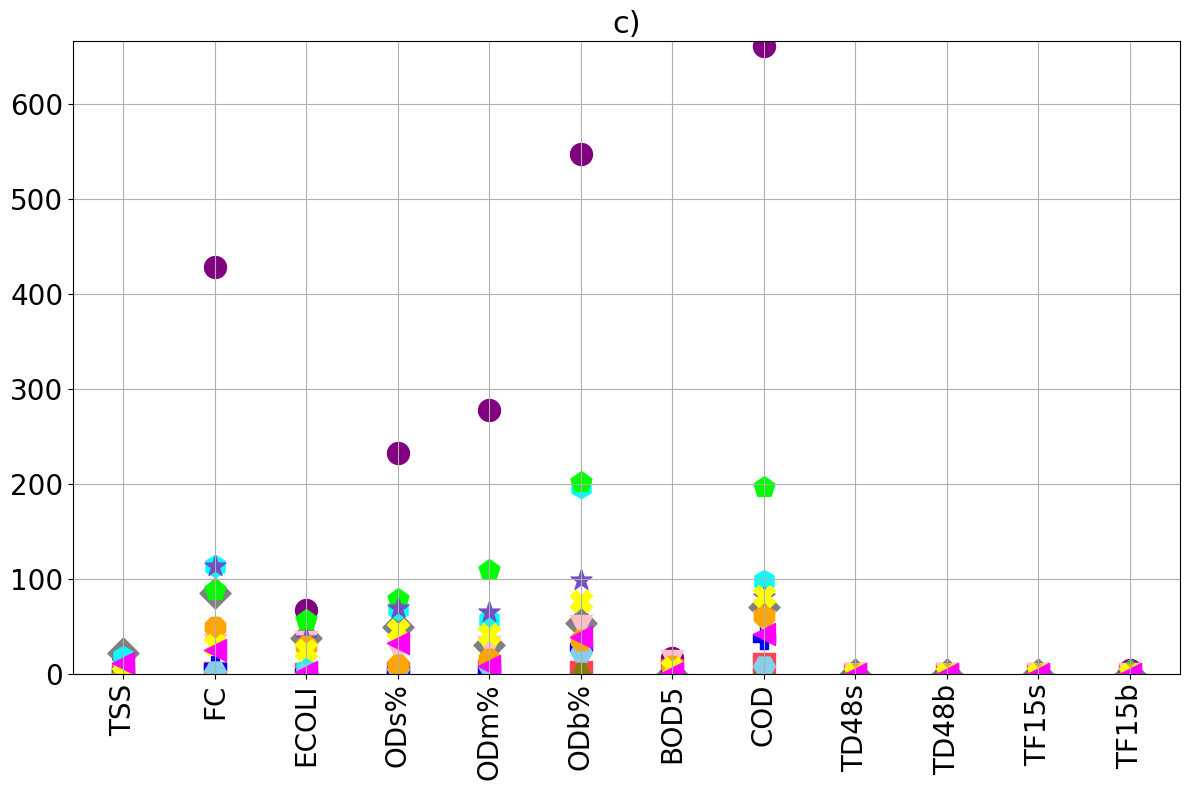

In [263]:
df1 = lentico_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits1 = {
    'SST': lambda x: x <= 150,
    'CF': lambda x: x <= 1000,
    'E_COLI': lambda x: x <= 850,
    'ODs%': lambda x: 30 < x <= 130,
    'ODm%': lambda x: 30 < x <= 130,
    'ODf%': lambda x: 30 < x <= 130,
    'DBO5': lambda x: x <= 30,
    'DQO': lambda x: x <= 40,
    'TOX_D48s': lambda x: x < 5,
    'TOX_D48f': lambda x: x < 5,
    'TOX_F15s': lambda x: x < 5,
    'TOX_F15f': lambda x: x < 5
}

# Crear una columna de cumplimiento para cada parámetro
for col, condition in limits1.items():
    df1[f'{col}_compliance'] = df1[col].apply(condition)

# Calcular el número total de no cumplimiento por parámetro para cada cuenca
non_compliance_summary1 = pd.DataFrame()
for col in limits1.keys():
    non_compliance_summary1[col] = df1.groupby('ORGANISMO CUENCA')[f'{col}_compliance'].apply(lambda x: x.size - x.sum())

# Diccionario para renombrar las columnas en el gráfico
column_names_mapping = {
    'SST': 'TSS',
    'CF': 'FC',
    'E_COLI': 'ECOLI',
    'ODs%': 'ODs%',
    'ODm%': 'ODm%',
    'ODf%': 'ODb%',
    'DBO5': 'BOD5',
    'DQO': 'COD',
    'TOX_D48s': 'TD48s',
    'TOX_D48f': 'TD48b',
    'TOX_F15s': 'TF15s',
    'TOX_F15f': 'TF15b'
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Colores y marcadores para cada cuenca
cuencas1 = {
    'LERMA SANTIAGO PACÍFICO': ('#800080', 'o'),
    'PENÍNSULA DE BAJA CALIFORNIA': ('#FF4550', 's'),
    'PENÍNSULA DE YUCATÁN': ('#808000', '^'),
    'RÍO BRAVO': ('#808080', 'D'),
    'CUENCAS CENTRALES DEL NORTE': ('#0000FF', 'P'),
    'PACÍFICO NORTE': ('#00FFFF', 'h'),
    'AGUAS DEL VALLE DE MÉXICO': ('#FFC0CB', 'v'),
    'BALSAS': ('#00FF00', 'p'),
    'GOLFO NORTE': ('#744EC2', '*'),
    'PACÍFICO SUR': ('#87CEEB', 'H'),
    'GOLFO CENTRO': ('#FFA500', '8'),
    'FRONTERA SUR': ('#FFFF00', 'X'),
    'NOROESTE': ('#FF00FF', '<'),
}

# Graficar puntos para cada cuenca y parámetro
for cuenca in cuencas1:
    for j, col in enumerate(limits1.keys()):
        color, marker = cuencas1.get(cuenca, ('gray', 'o'))
        ax.scatter(
            [column_names_mapping[col]],  # Usar los nombres mapeados
            [non_compliance_summary1.loc[cuenca, col]],
            marker=marker,
            color=color,
            label=f'{cuenca}' if j == 0 else "",
            s=250
        )

# Configuración del eje Y
ax.set_ylim(0, non_compliance_summary1.values.max() + 5)
ax.set_ylabel('', fontsize=20)
ax.tick_params(axis='y', labelsize=20)

# Configuración del eje X
ax.set_xlabel('', fontsize=14, fontweight='bold')
ax.set_xticks(list(column_names_mapping.values()))  # Mostrar los nombres mapeados
ax.set_xticklabels(list(column_names_mapping.values()), fontsize=20, rotation=90)
ax.tick_params(axis='x', labelsize=20)  # Tamaño de fuente del eje X

# Título del gráfico
ax.set_title('c)', fontsize=22)

# Ajustar la leyenda para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# (Descomentar si deseas incluir una leyenda)
# ax.legend(
#     by_label.values(),
#     by_label.keys(),
#     title='Cuencas',
#     title_fontsize=14,
#     fontsize=12,
#     loc='upper center',
#     bbox_to_anchor=(0.5, -0.1),
#     ncol=5
# )

# Agregar cuadrícula y mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


In [264]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          5429 non-null   object 
 1   CLAVE MONITOREO      5429 non-null   object 
 2   NOMBRE DEL SITIO     5429 non-null   object 
 3   TIPO CUERPO DE AGUA  5429 non-null   object 
 4   FECHA REALIZACIÓN    5429 non-null   object 
 5   AÑO                  5429 non-null   object 
 6   SST                  5429 non-null   float64
 7   CF                   5429 non-null   float64
 8   E_COLI               5429 non-null   float64
 9   ODs%                 5429 non-null   float64
 10  ODm%                 5429 non-null   float64
 11  ODf%                 5429 non-null   float64
 12  DBO5                 5429 non-null   float64
 13  DQO                  5429 non-null   float64
 14  TOX_D48s             5429 non-null   float64
 15  TOX_D48f             5429 non-null   f

##Data visualization

In [265]:
df_2012_al_2021_sp = df_2012_al_2021_sp.iloc[:, 6:20]
df_2012_al_2022_sp = df_2012_al_2022_sp.iloc[:, 6:20]
df_2012_al_2023_sp = df_2012_al_2023_sp.iloc[:, 6:20]

In [266]:
df_2012_al_2021_p = df_2012_al_2021_p.iloc[:, 6:20]
df_2012_al_2022_p = df_2012_al_2022_p.iloc[:, 6:20]
df_2012_al_2023_p = df_2012_al_2023_p.iloc[:, 6:20]

In [267]:
# Diccionario para renombrar las columnas
nombres_columnas = {
    'SST': 'TSS',
    'CF': 'FC',
    'E_COLI': 'ECOLI',
    'ODs%': 'ODs%',
    'ODm%': 'ODm%',
    'ODf%': 'ODb%',
    'DBO5': 'BOD5',
    'DQO': 'COD',
    'TOX_D48s': 'TD48s',
    'TOX_D48f': 'TD48b',
    'TOX_F15s': 'TF15s',
    'TOX_F15f': 'TF15b'
}

# Renombrar las columnas
df_2012_al_2021_sp = df_2012_al_2021_sp.rename(columns=nombres_columnas)

# Renombrar las columnas
df_2012_al_2021_p = df_2012_al_2021_p.rename(columns=nombres_columnas)

###Mapa de calor de simbolos > y <

####al 2021

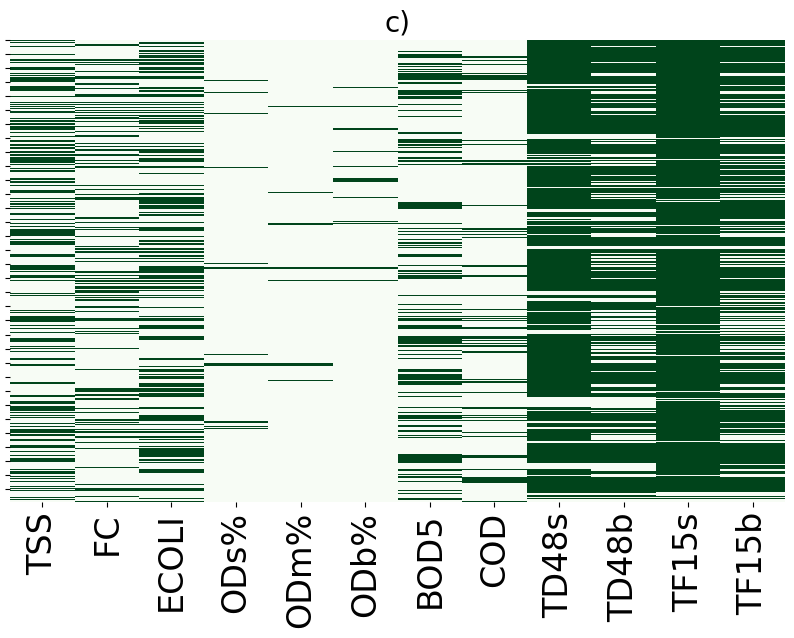

In [268]:
# Crear una matriz booleana donde True indica presencia de < o >
bool_matrix = df_2012_al_2021_sp.applymap(lambda x: '<' in str(x) or '>' in str(x))

# Crear un heatmap de la matriz booleana para todas las columnas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar el heatmap basado en la matriz booleana
heatmap = sns.heatmap(bool_matrix, cbar=False, cmap='Greens')  # Usar 'Greens'

# Rotar las etiquetas del eje X 90 grados y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje Y a una lista vacía para eliminarlas
heatmap.set_yticklabels([])

# Configurar el título y la etiqueta del eje X
plt.title('c)', loc='center', fontsize=20)
plt.xlabel('', loc='center', fontsize=20)

# Mostrar el heatmap
plt.show()


####al 2022

####al 2023

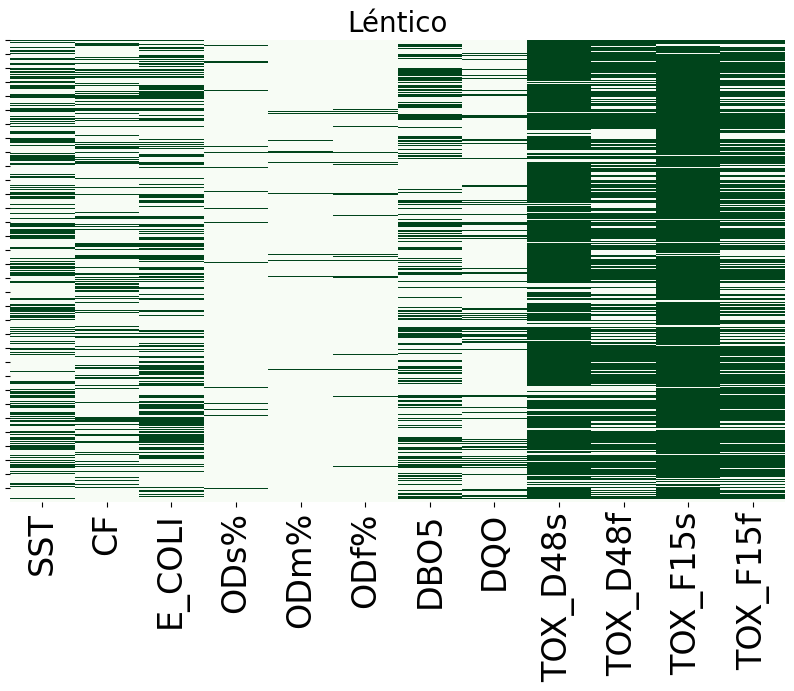

In [269]:
# Crear una matriz booleana donde True indica presencia de < o >
bool_matrix = df_2012_al_2023_sp.applymap(lambda x: '<' in str(x) or '>' in str(x))

# Crear un heatmap de la matriz booleana para todas las columnas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar el heatmap basado en la matriz booleana
heatmap = sns.heatmap(bool_matrix, cbar=False, cmap='Greens')  # Usar 'Greens'

# Rotar las etiquetas del eje X 90 grados y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje Y a una lista vacía para eliminarlas
heatmap.set_yticklabels([])

# Configurar el título y la etiqueta del eje X
plt.title('Léntico', loc='center', fontsize=20)
plt.xlabel('', loc='center', fontsize=20)

# Mostrar el heatmap
plt.show()


###Mapa de calor de valores nulos

####al 2021

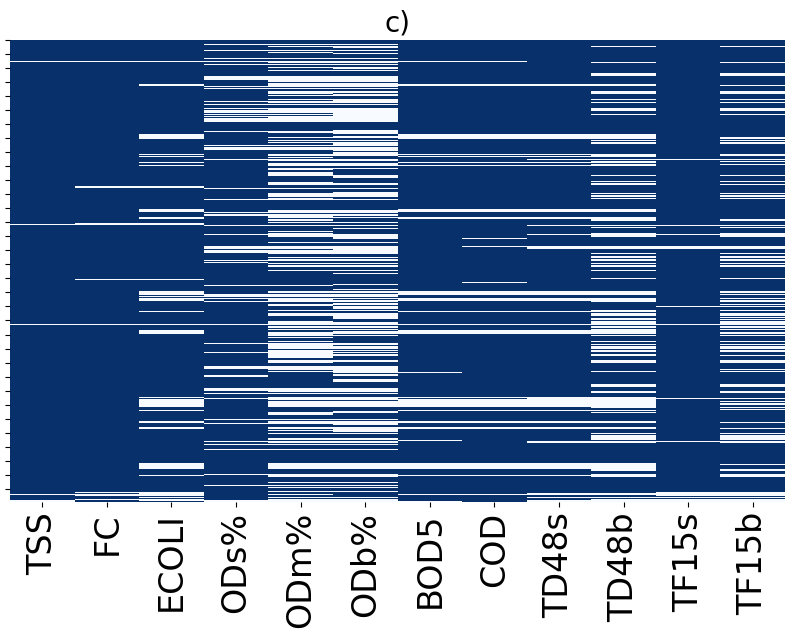

In [270]:
# Seleccionar las columnas que deseas incluir en el mapa de calor
columnas_seleccionadas_lentico = df_2012_al_2021_sp.columns  # Reemplaza con el rango de nombres de columnas que deseas

# Crear un mapa de calor de valores faltantes para todas las columnas del DataFrame
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar un mapa de calor mostrando la presencia de valores faltantes
heatmap = sns.heatmap(df_2012_al_2021_sp.isnull(), cbar=False, cmap='Blues_r')

# Rotar las etiquetas del eje x 90 grados para que sean verticales y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje y como una lista vacía para eliminarlas
heatmap.set_yticklabels([])

plt.title('c)', loc='center', fontsize=20)  # Título del gráfico
plt.xlabel('', loc='center', fontsize=20)  # Etiqueta del eje x
plt.show()  # Muestra el gráfico

####al 2022

####al_2023

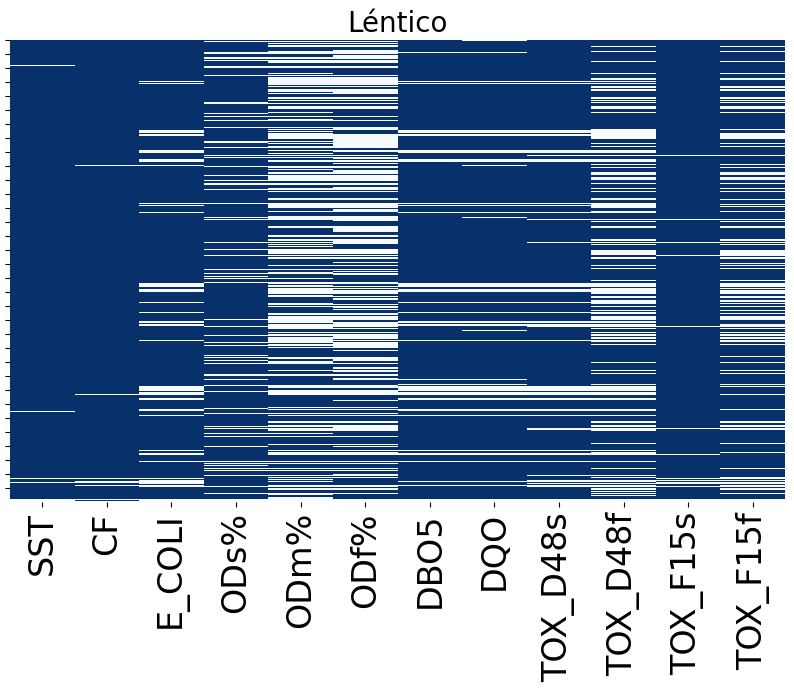

In [271]:
# Seleccionar las columnas que deseas incluir en el mapa de calor
columnas_seleccionadas_lentico = df_2012_al_2023_sp.columns  # Reemplaza con el rango de nombres de columnas que deseas

# Crear un mapa de calor de valores faltantes solo para las columnas seleccionadas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Genera un mapa de calor que muestra la presencia de valores faltantes en las columnas seleccionadas
heatmap = sns.heatmap(df_2012_al_2023_sp[columnas_seleccionadas_lentico].isnull(), cbar=False, cmap='Blues_r')

# Rotea las etiquetas del eje x 90 grados para que sean verticales y aumenta el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establece las etiquetas del eje y como una lista vacía para eliminarlas
heatmap.set_yticklabels([])

plt.title('Léntico', loc='center', fontsize=20)  # Título del gráfico
plt.xlabel('', loc='center', fontsize=20)  # Etiqueta del eje x
plt.show()  # Muestra el gráfico


###Mapa de calor de correlación de valores nulos entre contaminantes

####al 2021

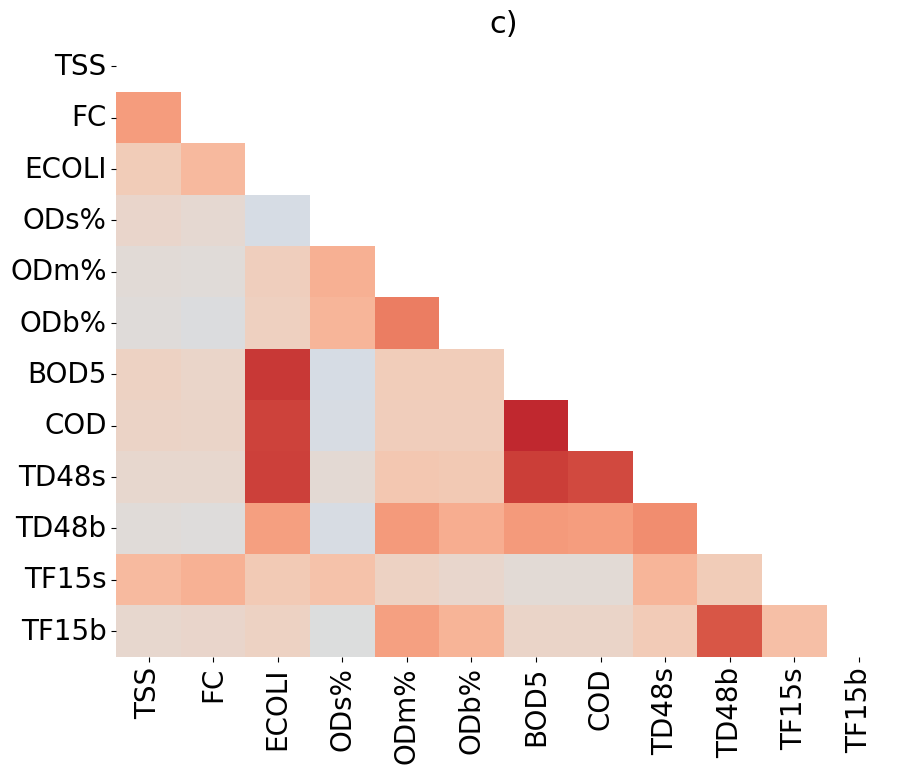

In [272]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2021_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('c)', fontsize=22)
plt.show()


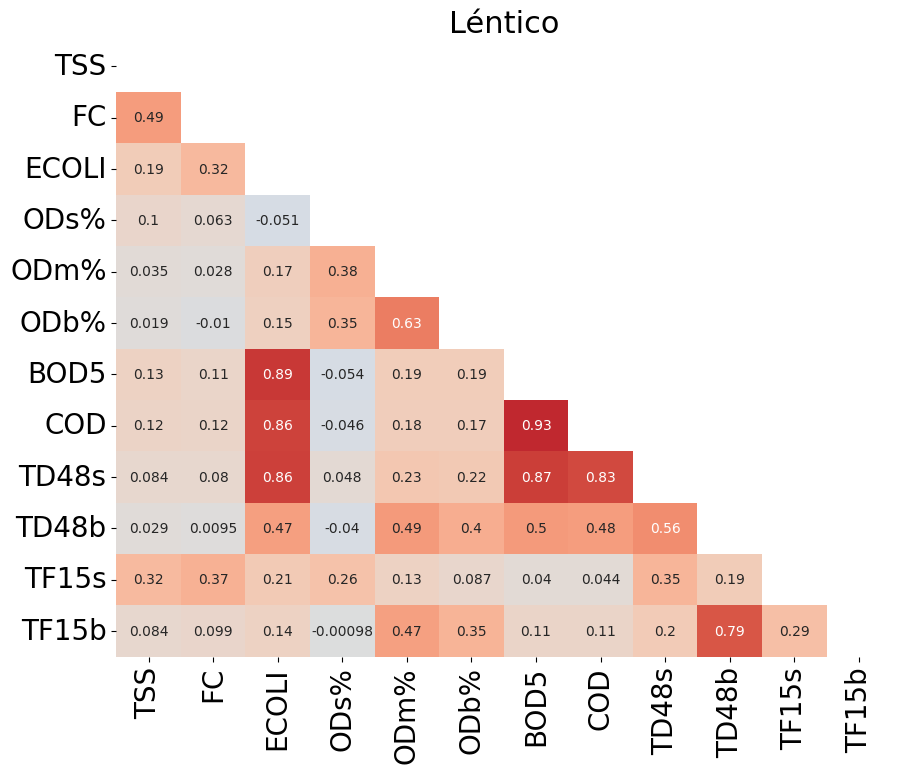

In [273]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2021_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico', fontsize=22)
plt.show()

####al 2022

####al 2023

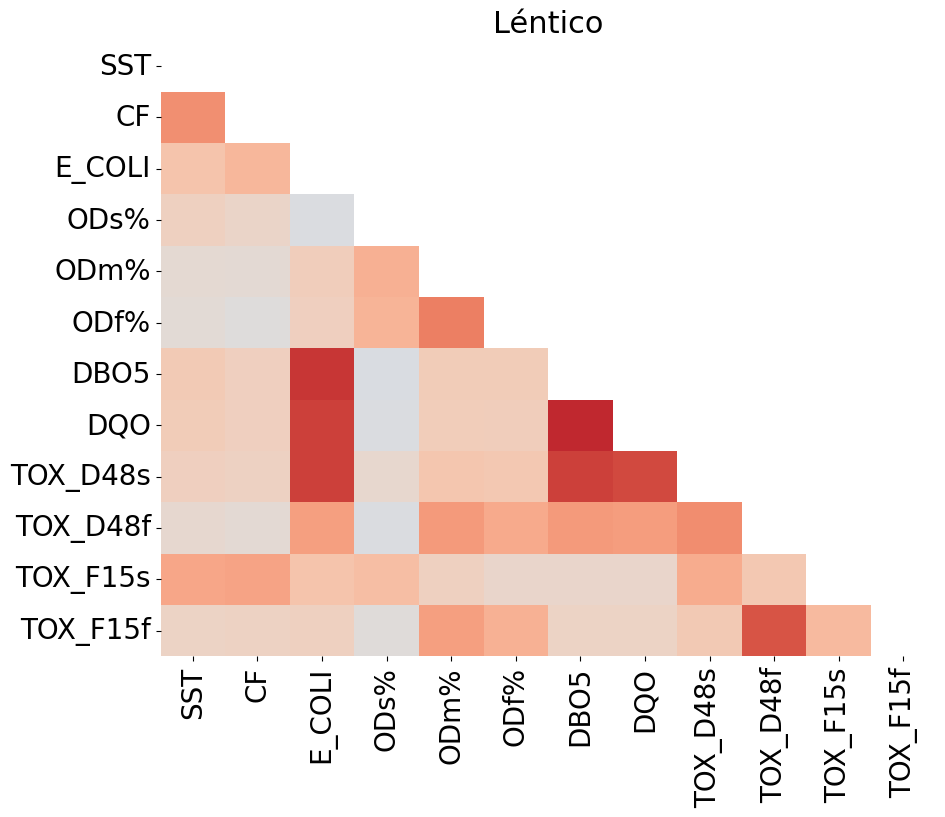

In [274]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2023_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico', fontsize=22)
plt.show()


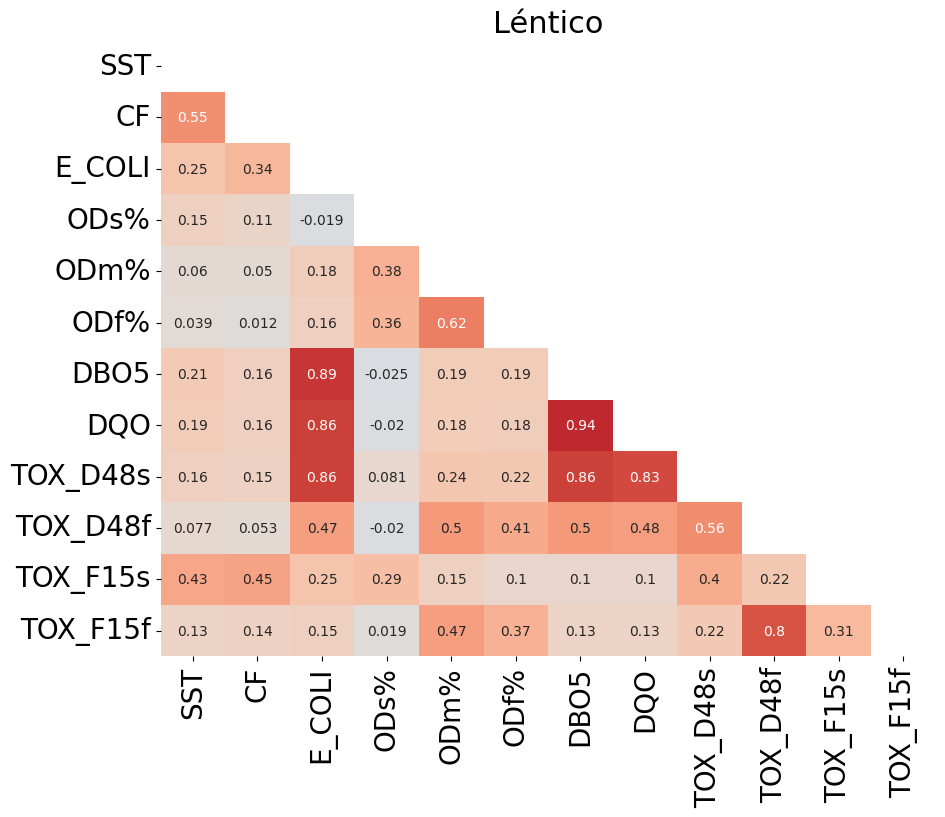

In [275]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2023_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico', fontsize=22)
plt.show()

###Mapa de calor de correlación lineal

####al 2021

#####Coeficiente de correlación de Pearson

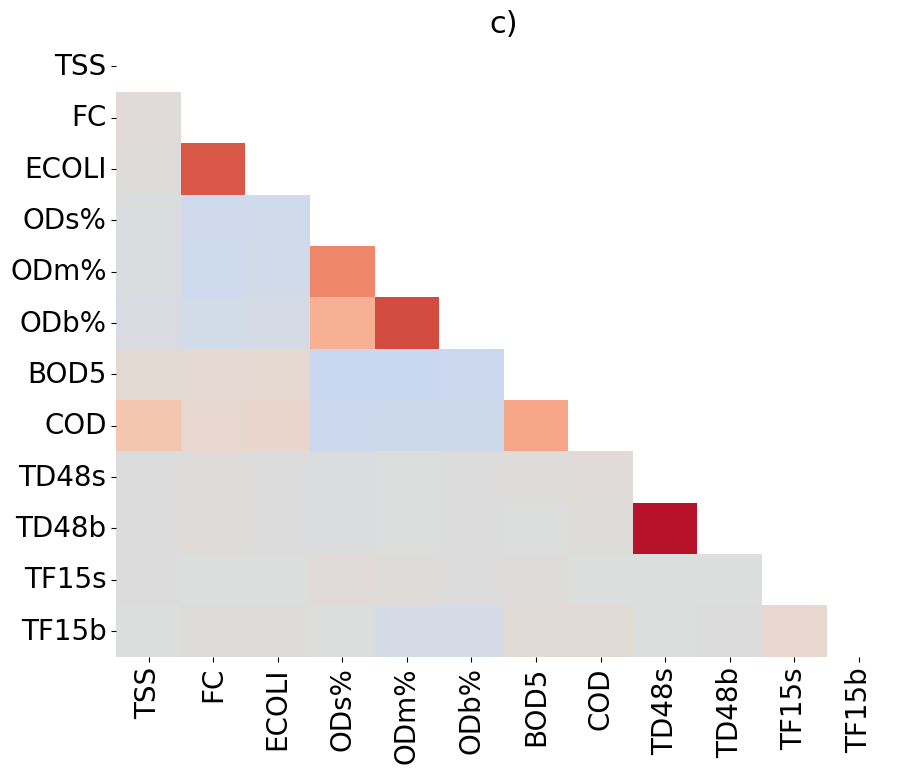

In [276]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('c)', fontsize=22)

# Mostrar el gráfico
plt.show()

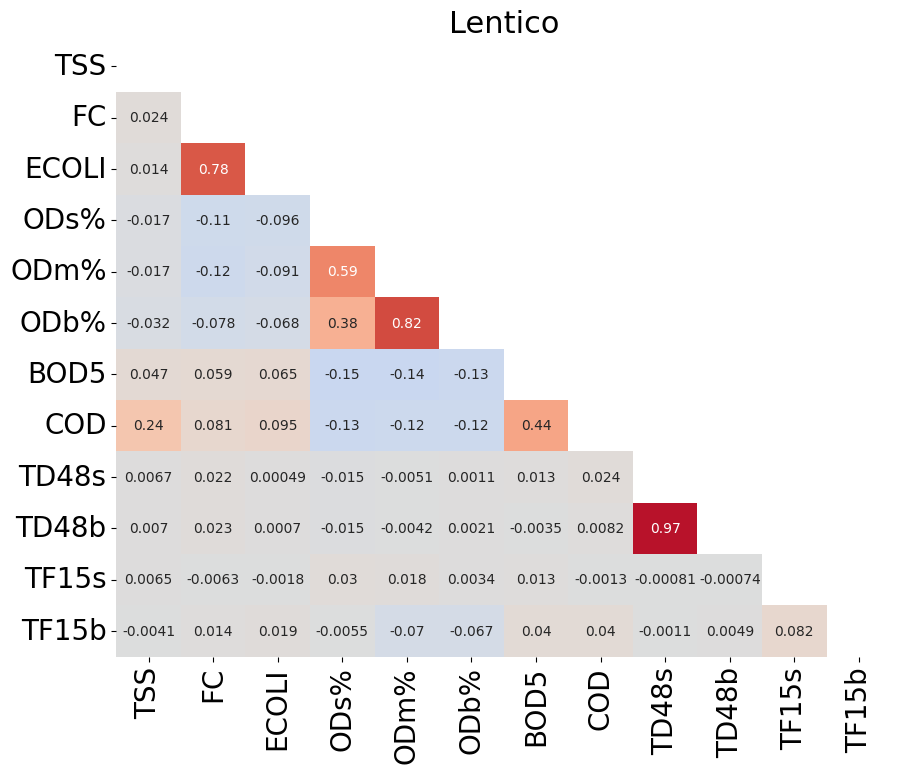

In [277]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Lentico', fontsize=22)

# Mostrar el gráfico
plt.show()

#####Coeficiente de correlación de Spearman

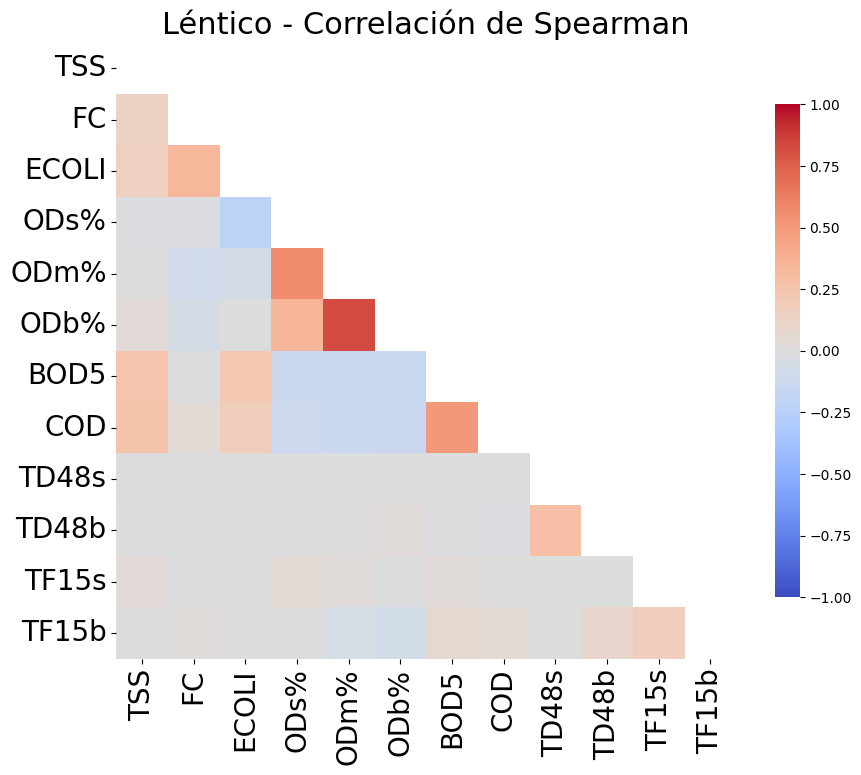

In [278]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


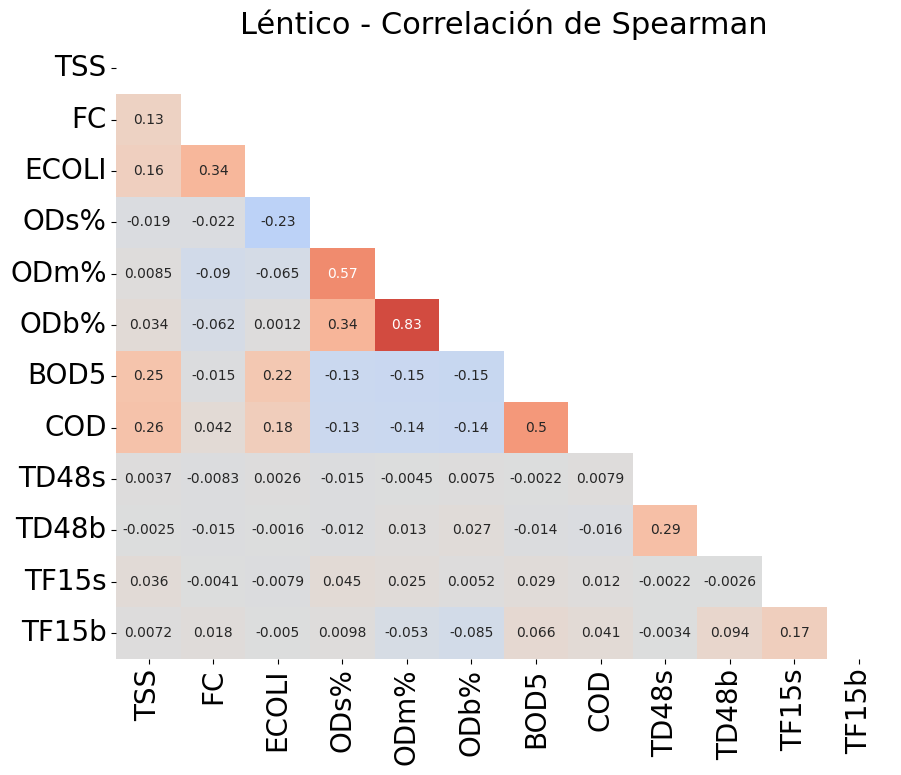

In [279]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


####al 2022

####al 2023

#####Coeficiente de correlación de Pearson

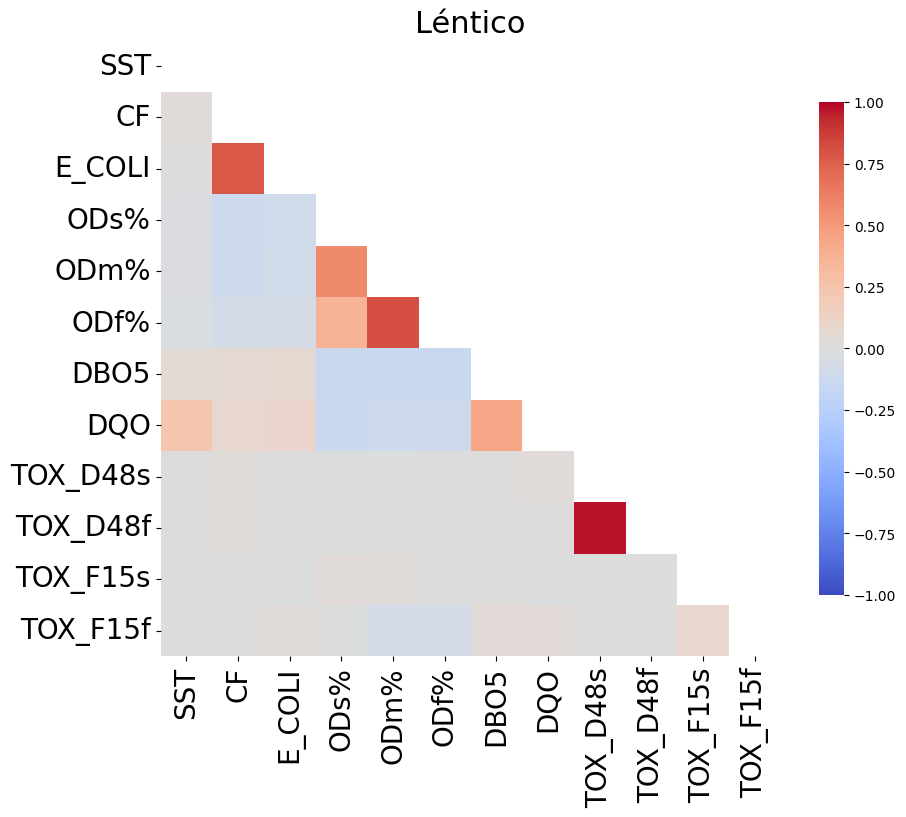

In [280]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico', fontsize=22)

# Mostrar el gráfico
plt.show()

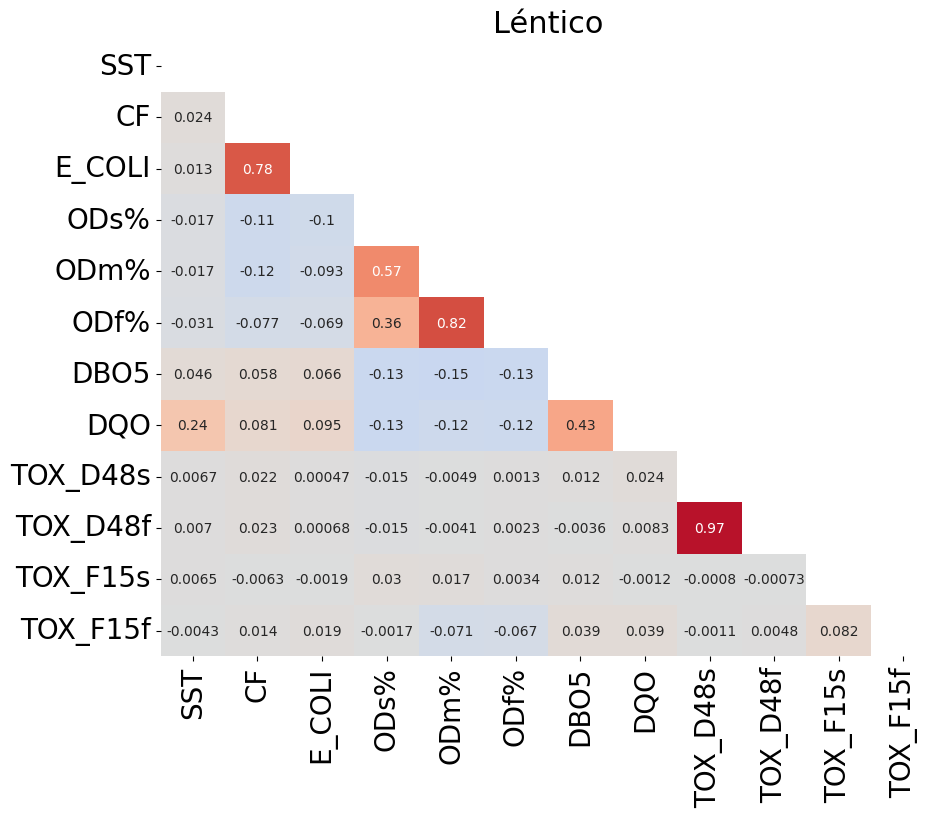

In [281]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico', fontsize=22)

# Mostrar el gráfico
plt.show()

#####Coeficiente de correlación de Spearman

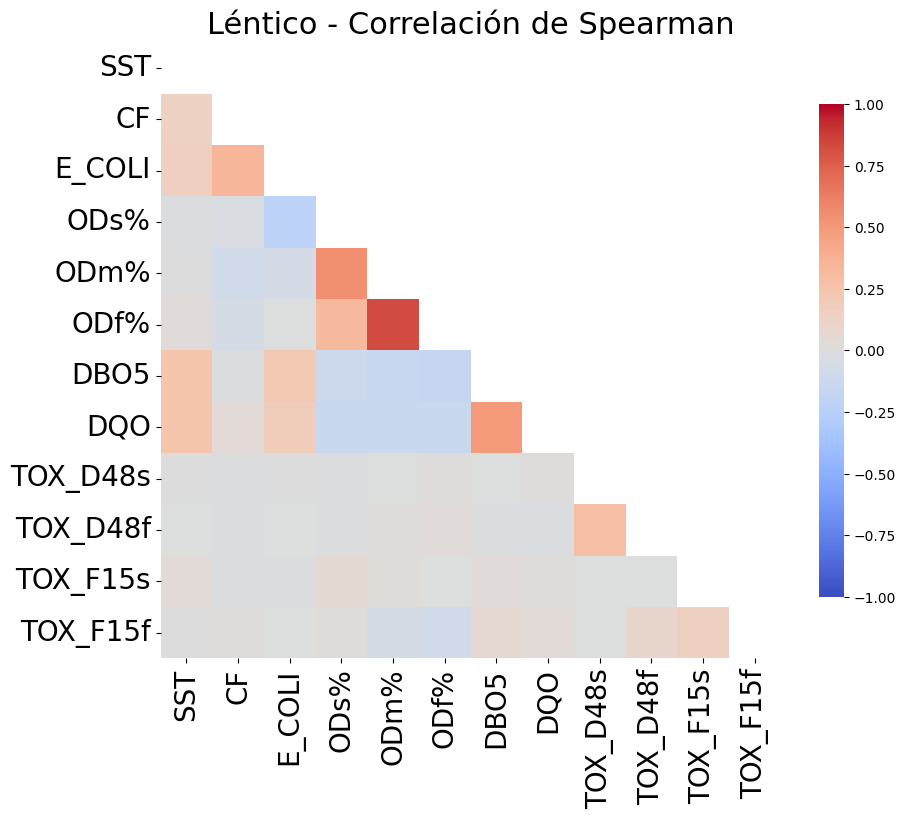

In [282]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


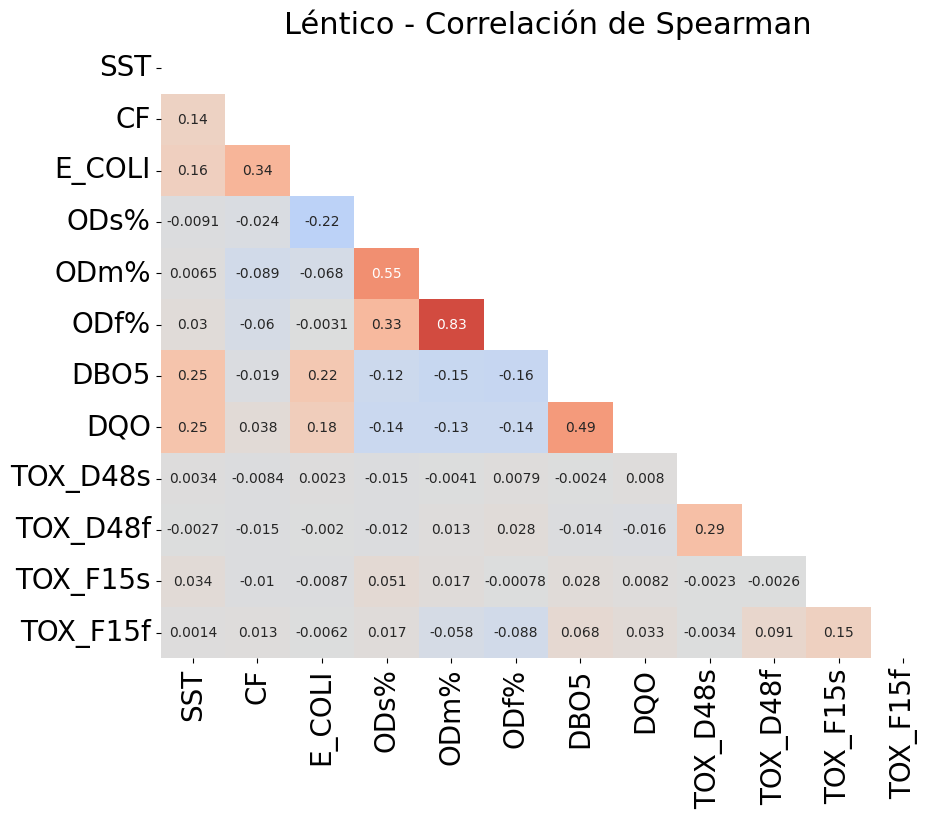

In [283]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Léntico - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


###Mapa de calor de correlacion entre variables independientes y variable objetivo

####al 2021

Matriz de coeficientes Eta:
       Water quality
TSS         0.090234
FC          0.203971
ECOLI       0.098206
ODs%        0.118355
ODm%        0.310685
ODb%        0.387878
BOD5        0.393014
COD         0.664595
TD48s       0.022304
TD48b       0.020293
TF15s       0.024701
TF15b       0.061229


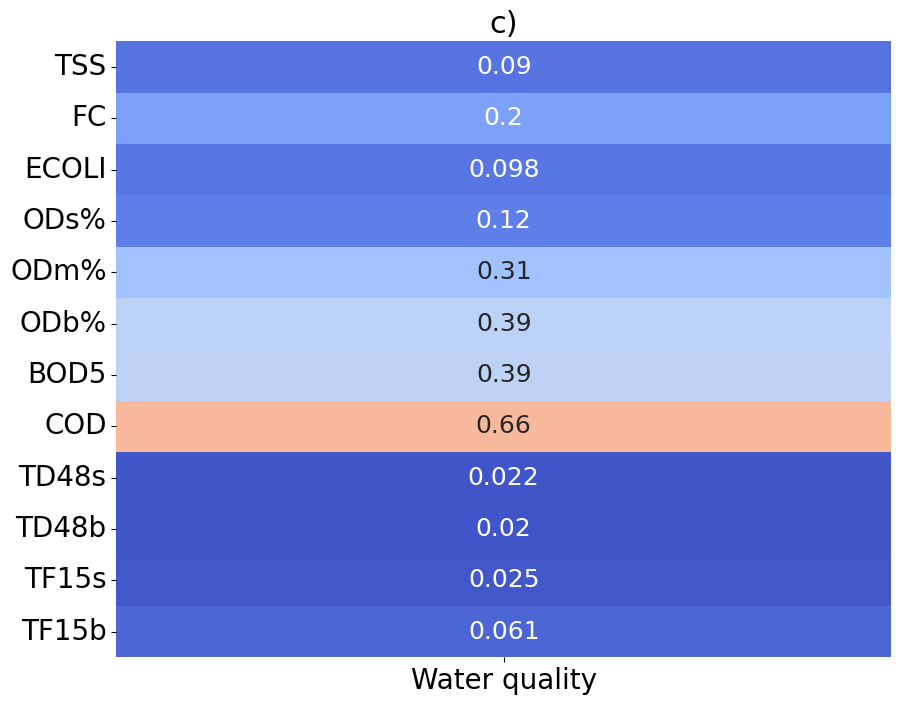

In [284]:
# Función para calcular el coeficiente Eta
def coeficiente_eta(categorica, numerica):
    categorias = categorica.unique()
    medias_grupo = numerica.groupby(categorica).mean()
    media_total = numerica.mean()

    # Suma de cuadrados entre grupos
    ss_between = sum(categorica.value_counts()[cat] * (medias_grupo[cat] - media_total)**2 for cat in categorias)
    # Suma de cuadrados totales
    ss_total = sum((numerica - media_total)**2)

    # Coeficiente Eta
    eta = np.sqrt(ss_between / ss_total)
    return eta

# Función para calcular y graficar el mapa de calor del coeficiente Eta
def graficar_coeficiente_eta(df, variable_categorica, variables_numericas, nombres_mostrados=None):
    # Si se proporcionan nombres renombrados, construir un diccionario para mapear
    if nombres_mostrados:
        nombres_dict = dict(zip(variables_numericas, nombres_mostrados))
    else:
        nombres_dict = {col: col for col in variables_numericas}  # Mismos nombres si no se proporcionan nuevos

    # Crear una matriz de coeficientes Eta
    eta_matrix = pd.DataFrame(index=nombres_mostrados if nombres_mostrados else variables_numericas,
                              columns=["Water quality"])  # Cambiar el título de la columna a "Water quality"

    for var in variables_numericas:
        eta_matrix.loc[nombres_dict[var], "Water quality"] = coeficiente_eta(df[variable_categorica], df[var])

    # Convertir a tipo float para visualización
    eta_matrix = eta_matrix.astype(float)

    # Imprimir los valores calculados
    print("Matriz de coeficientes Eta:")
    print(eta_matrix)

    # Crear un mapa de calor
    plt.figure(figsize=(10, 8))
    # Aumentar el tamaño de la letra de las anotaciones
    sns.heatmap(eta_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar=False, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 18})  # Puedes cambiar el valor de 'size' para hacer el texto más grande

    # Personalización del gráfico
    plt.title('c)', fontsize=22)
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.xlabel("", fontsize=20)  # Cambiar etiqueta del eje x
    plt.show()

    # Ejemplo de uso con nombres personalizados:
graficar_coeficiente_eta(
    df=df_lentico_calidad_del_agua_2021,
    variable_categorica='Calidad del agua',
    variables_numericas=['SST', 'CF', 'E_COLI', 'ODs%', 'ODm%', 'ODf%', 'DBO5', 'DQO', 'TOX_D48s', 'TOX_D48f','TOX_F15s','TOX_F15f',],
    nombres_mostrados=['TSS', 'FC', 'ECOLI', 'ODs%', 'ODm%', 'ODb%', 'BOD5', 'COD', 'TD48s', 'TD48b', 'TF15s', 'TF15b']
)

####al 2022

####al 2023

##Template

In [285]:
lentico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15427 entries, 0 to 15426
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          15427 non-null  object 
 1   CLAVE MONITOREO      15427 non-null  object 
 2   NOMBRE DEL SITIO     15427 non-null  object 
 3   TIPO CUERPO DE AGUA  15427 non-null  object 
 4   FECHA REALIZACIÓN    15427 non-null  object 
 5   AÑO                  15427 non-null  object 
 6   SST                  15175 non-null  float64
 7   CF                   15078 non-null  float64
 8   E_COLI               13362 non-null  float64
 9   ODs%                 13338 non-null  float64
 10  ODm%                 8305 non-null   float64
 11  ODf%                 7746 non-null   float64
 12  DBO5                 13532 non-null  float64
 13  DQO                  13384 non-null  float64
 14  TOX_D48s             13243 non-null  float64
 15  TOX_D48f             10152 non-null 

In [286]:
lentico_template = lentico.copy()

In [287]:
# Filtrar el DataFrame original para que solo incluya las filas donde el año es 2022
lentico_template = lentico[lentico['AÑO'].isin([2022])]

In [288]:
lentico_template = lentico_template.reset_index(drop=True)

In [289]:
# Reemplazar los caracteres específicos en las columnas seleccionadas
columns = ['SST', 'CF', 'E_COLI', 'ODs%', 'ODm%', 'ODf%','DBO5', 'DQO', 'TOX_D48s', 'TOX_D48f','TOX_F15s', 'TOX_F15f']  # Asegúrate de ajustar 'columns' según tus necesidades

# Usar .loc para evitar el SettingWithCopyWarning
lentico_template.loc[:, columns] = lentico_template[columns].replace({'<':'', '>':'', '≤':'', '≥':''}, regex=True)


In [290]:
lentico_template.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          476 non-null    object 
 1   CLAVE MONITOREO      476 non-null    object 
 2   NOMBRE DEL SITIO     476 non-null    object 
 3   TIPO CUERPO DE AGUA  476 non-null    object 
 4   FECHA REALIZACIÓN    476 non-null    object 
 5   AÑO                  476 non-null    object 
 6   SST                  396 non-null    float64
 7   CF                   399 non-null    float64
 8   E_COLI               380 non-null    float64
 9   ODs%                 385 non-null    float64
 10  ODm%                 147 non-null    float64
 11  ODf%                 252 non-null    float64
 12  DBO5                 391 non-null    float64
 13  DQO                  393 non-null    float64
 14  TOX_D48s             348 non-null    float64
 15  TOX_D48f             225 non-null    flo

In [291]:
# Eliminar filas con valores nulos en las columnas 'Alk', 'Cond' y 'Hard'
lentico_template = lentico_template.dropna(subset=['SST', 'CF', 'E_COLI', 'ODs%', 'ODm%', 'ODf%','DBO5', 'DQO', 'TOX_D48s', 'TOX_D48f','TOX_F15s', 'TOX_F15f'])

In [292]:
lentico_template.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 0 to 377
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          126 non-null    object 
 1   CLAVE MONITOREO      126 non-null    object 
 2   NOMBRE DEL SITIO     126 non-null    object 
 3   TIPO CUERPO DE AGUA  126 non-null    object 
 4   FECHA REALIZACIÓN    126 non-null    object 
 5   AÑO                  126 non-null    object 
 6   SST                  126 non-null    float64
 7   CF                   126 non-null    float64
 8   E_COLI               126 non-null    float64
 9   ODs%                 126 non-null    float64
 10  ODm%                 126 non-null    float64
 11  ODf%                 126 non-null    float64
 12  DBO5                 126 non-null    float64
 13  DQO                  126 non-null    float64
 14  TOX_D48s             126 non-null    float64
 15  TOX_D48f             126 non-null    float64


In [293]:
lentico_template.to_csv("lentico_template.csv")

##Model training

#####Separación de los datos en conjuntos de entrenamiento y prueba

In [294]:
# Crea un nuevo DataFrame para el entrenamiento del modelo con datos desde 2012 hasta 2021, excluyendo los años 2022 y 2023
train_lentic = data_lentico[(data_lentico['AÑO'] != 2022) & (data_lentico['AÑO'] != 2023)]

# Crea un nuevo DataFrame para validación que consiste únicamente en datos de los años 2022 y 2023
val_lentic = data_lentico[(data_lentico['AÑO'] == 2022) | (data_lentico['AÑO'] == 2023)]

In [295]:
# Selecciona columnas para el entrenamiento del modelo, incluyendo las columnas de contaminantes y la variable objetivo 'Calidad del agua' para el conjunto de datos de 2012 a 2021
train_lentic_num = train_lentic.iloc[:, list(range(6, 18)) + [42]]
train_lentic_num.head()

,SST,CF,E_COLI,ODs%,ODm%,ODf%,DBO5,DQO,TOX_D48s,TOX_D48f,TOX_F15s,TOX_F15f,Calidad del agua
0,10.0,3.0,3.0,10.0,10.0,10.0,2.34,19.776,1.0,1.0,1.0,1.0,1
3,10.0,1728.0,86.0,137.9,61.8,36.5,9.00,35.000,1.0,1.0,1.0,1.0,1
4,10.0,160.0,1.0,102.1,37.5,28.7,4.20,44.740,1.0,1.0,1.0,1.0,2
5,10.0,63.0,1.0,114.6,37.0,37.0,2.00,10.000,1.0,1.0,1.0,1.0,0
6,10.0,426.0,1.0,115.6,26.4,30.8,4.66,36.790,1.0,1.0,1.0,1.0,1


In [296]:
# Muestra el tamaño del DataFrame de entrenamiento
train_lentic_num.shape

(5303, 13)

In [297]:
# Selecciona columnas para el entrenamiento del modelo, incluyendo las columnas de contaminantes y la variable objetivo 'Calidad del agua' para el conjunto de datos del año 2022
val_lentic_num = val_lentic.iloc[:, list(range(6, 18)) + [42]]
val_lentic_num.head()

,SST,CF,E_COLI,ODs%,ODm%,ODf%,DBO5,DQO,TOX_D48s,TOX_D48f,TOX_F15s,TOX_F15f,Calidad del agua
14951,21.2,288.0,41.0,114.9,56.6,23.3,2.00,10.00,1.0,1.0,1.0,1.0,1
14958,19.0,2400.0,2400.0,54.0,40.0,36.0,2.13,27.96,1.0,1.0,1.0,1.0,1
14959,10.0,435.0,10.0,96.7,91.6,71.5,2.00,10.00,1.0,1.0,1.0,1.0,0
14960,25.2,384.0,10.0,103.5,94.2,80.4,2.00,10.00,1.0,1.0,1.0,1.0,0
14973,16.0,460.0,240.0,62.4,38.7,24.5,20.82,38.40,1.0,1.0,1.0,1.0,1


In [298]:
# Muestra el tamaño del DataFrame de validación
val_lentic_num.shape

(126, 13)

Separación de la variable dependiente (y) de las variables independientes (X)

In [299]:
# Separa las características (X_val_lentico) y la variable objetivo (y_val_lentico) para la validación
X_train_lentic_num = train_lentic_num.drop(columns=['Calidad del agua'])
y_train_lentic_num = train_lentic_num['Calidad del agua']

In [300]:
# Separa las características (X_val_lentico) y la variable objetivo (y_val_lentico) para la validación
X_val_lentic_num = val_lentic_num.drop(columns=['Calidad del agua'])
y_val_lentic_num = val_lentic_num['Calidad del agua']

In [301]:
X_train_lentic_num.shape, y_train_lentic_num.shape, X_val_lentic_num.shape, y_val_lentic_num.shape,

((5303, 12), (5303,), (126, 12), (126,))

In [302]:
# Guardar el conjunto de entrenamiento en un archivo Excel
#X_train_lentic.to_excel("train_data_ub_lentic.xlsx", index=False)
#y_train_lentic.to_excel("train_labels_data_ub_lentic.xlsx", index=False)

# Guardar el conjunto de prueba en un archivo Excel
#X_ub_num_test_lentic.to_excel("test_data_ub_lentic.xlsx", index=False)
#y_ub_num_test_lentic.to_excel("test_labels_data_ub_lentic.xlsx", index=False)

In [303]:
# Calcula el conteo de clases presentes en la columna 'Water quality'
conteo_clases = train_lentic_num['Calidad del agua'].value_counts()

# Imprime el conteo de clases
print(conteo_clases)

Calidad del agua
0    2325
1    1570
2    1408
Name: count, dtype: int64


In [304]:
# Calcula el conteo de clases presentes en la columna 'Water quality' del conjunto de validación
conteo_clases = val_lentic_num['Calidad del agua'].value_counts()

# Imprime el conteo de clases
print(conteo_clases)

Calidad del agua
1    81
0    39
2     6
Name: count, dtype: int64


In [305]:
X_train, X_test, y_train, y_test = train_test_split(X_train_lentic_num, y_train_lentic_num, test_size= 0.2, random_state=42)

In [306]:
# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###With grid search and cross validation

####Unbalanced classes

#####XGBOOST

In [307]:
# Define a dictionary of hyperparameters for tuning a XGBoost model
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_xgb = XGBClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_xgb, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_xgb.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}, Accuracy: 0.9943449575871819, Best score (cv): 0.9943418450118898
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimato

######Metrics

 Evaluate the model on the training set

In [308]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9992927864214993
Precision:  0.9992928453010765
Precision per class: [0.99946237 0.9992126  0.99910072]
Recall:  0.9992927864214993
Recall per class: [0.99892531 1.         0.99910072]
F1 Score:  0.9992927378148238
F1-score for the class 0: 0.999193765116904
F1-score for the class 1: 0.9996061441512406
F1-score for the class 2: 0.9991007194244604
jaccard: 0.9985865618853258
Confusion Matrix: 
[[1859    1    1]
 [   0 1269    0]
 [   1    0 1111]]


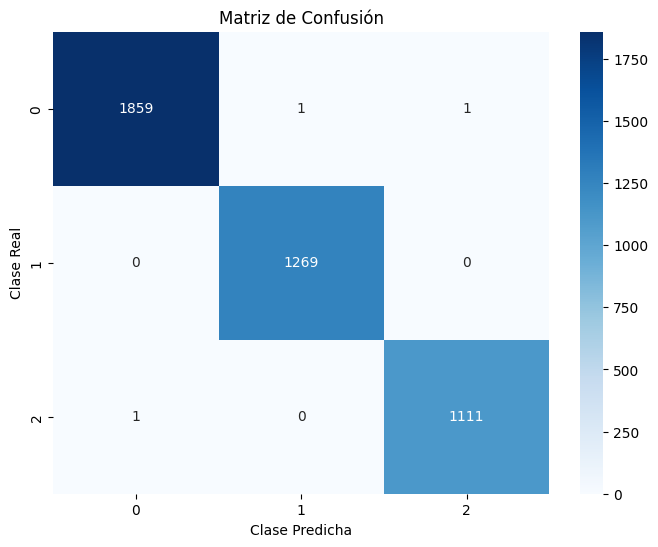

In [309]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [310]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9943449575871819
Precision:  0.9943548230643235
Precision per class: [0.99141631 0.9966443  0.996633  ]
Recall:  0.9943449575871819
Recall per class: [0.99568966 0.98671096 1.        ]
F1 Score:  0.9943400319652309
F1-score for the class 0: 0.9935483870967742
F1-score for the class 1: 0.991652754590985
F1-score for the class 2: 0.9983136593591906
jaccard: 0.9985865618853258
Confusion Matrix: 
[[462   1   1]
 [  4 297   0]
 [  0   0 296]]


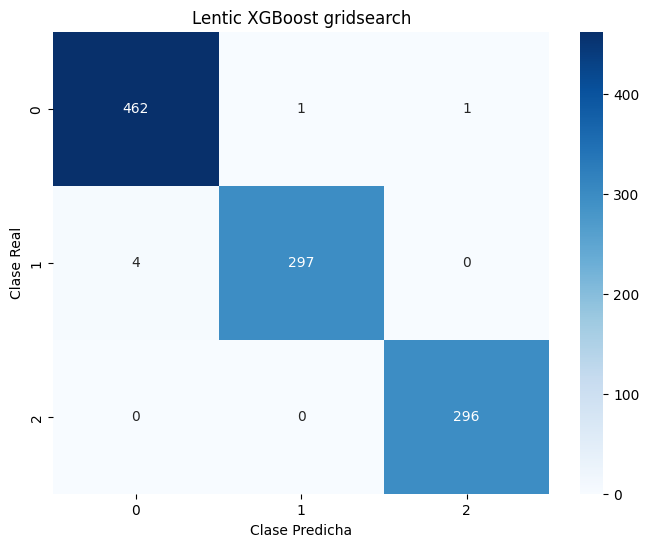

In [311]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic XGBoost gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [312]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[39  0  0]
 [ 0 81  0]
 [ 0  0  6]]


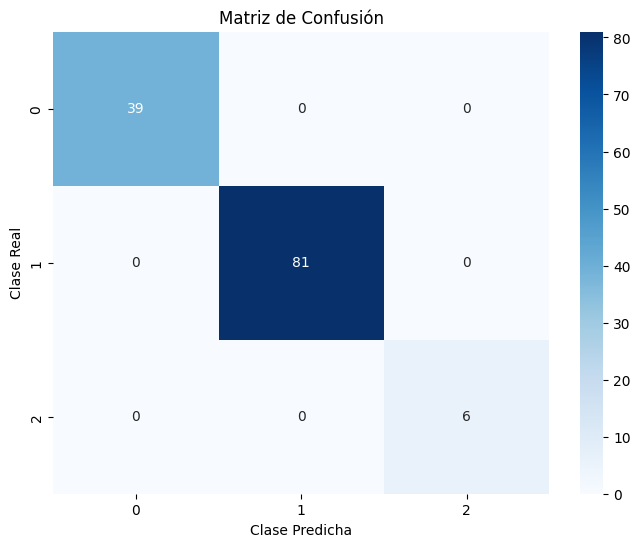

In [313]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####SVM

In [314]:
# Define a dictionary of hyperparameters for tuning a SVM model
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_svm = SVC()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_svm, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_svm_bin.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, Accuracy: 0.9500471253534402, Best score (cv): 0.9497913749805542
Best model: SVC(C=10, gamma=0.1)
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.9497913749805542


######Metrics

 Evaluate the model on the training set

In [315]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9677039132484677
Precision:  0.967682220538373
Precision per class: [0.96274614 0.95763389 0.98741007]
Recall:  0.9677039132484677
Recall per class: [0.97205803 0.94405043 0.98741007]
F1 Score:  0.9676687236550786
F1-score for the class 0: 0.967379679144385
F1-score for the class 1: 0.9507936507936507
F1-score for the class 2: 0.987410071942446
jaccard: 0.9377043775669416
Confusion Matrix: 
[[1809   48    4]
 [  61 1198   10]
 [   9    5 1098]]


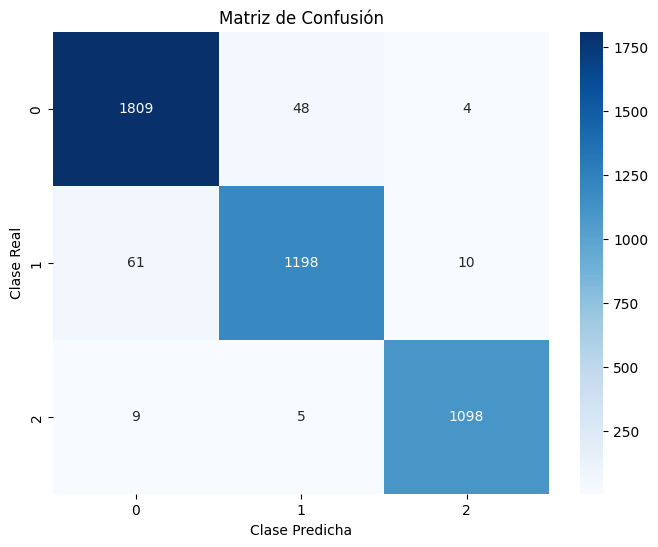

In [316]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [317]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9500471253534402
Precision:  0.949998658044257
Precision per class: [0.95309168 0.92281879 0.97278912]
Recall:  0.9500471253534402
Recall per class: [0.96336207 0.91362126 0.96621622]
F1 Score:  0.9500012145387636
F1-score for the class 0: 0.9581993569131833
F1-score for the class 1: 0.9181969949916527
F1-score for the class 2: 0.9694915254237289
jaccard: 0.9377043775669416
Confusion Matrix: 
[[447  15   2]
 [ 20 275   6]
 [  2   8 286]]


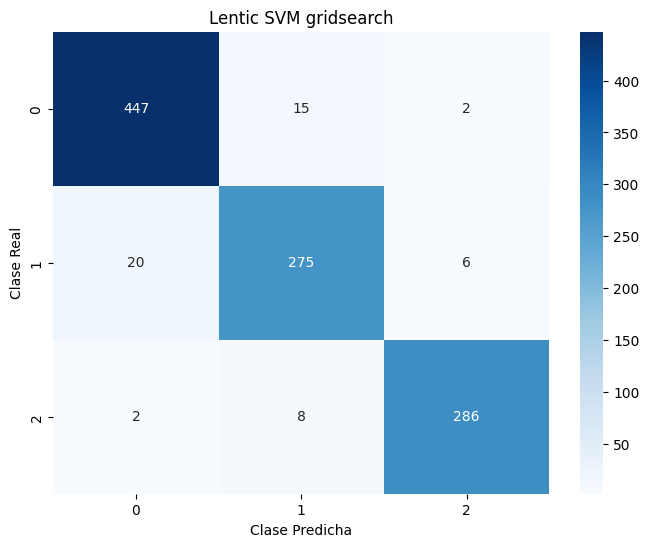

In [318]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic SVM gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [319]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9285714285714286
Precision:  0.9293083900226757
Precision per class: [0.8974359  0.95       0.85714286]
Recall:  0.9285714285714286
Recall per class: [0.8974359 0.9382716 1.       ]
F1 Score:  0.9286548510150994
F1-score for the class 0: 0.8974358974358975
F1-score for the class 1: 0.9440993788819876
F1-score for the class 2: 0.9230769230769231
jaccard: 0.8675442269931228
Confusion Matrix: 
[[35  4  0]
 [ 4 76  1]
 [ 0  0  6]]


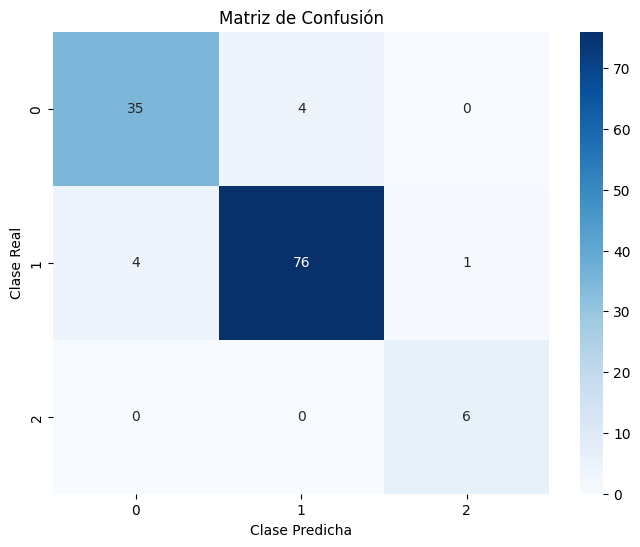

In [320]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####KNN

In [321]:
# Define a dictionary of hyperparameters for tuning a KNN model
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'p': [1, 2]  # Parámetro para la distancia (1 para la distancia de Manhattan, 2 para la Euclidiana)
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_knn = KNeighborsClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_knn, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_knn_bin.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}, Accuracy: 0.885956644674835, Best score (cv): 0.9028735249016601
Best model: KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')
Best params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best score: 0.9028735249016601


######Metrics

 Evaluate the model on the training set

In [322]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[1861    0    0]
 [   0 1269    0]
 [   0    0 1112]]


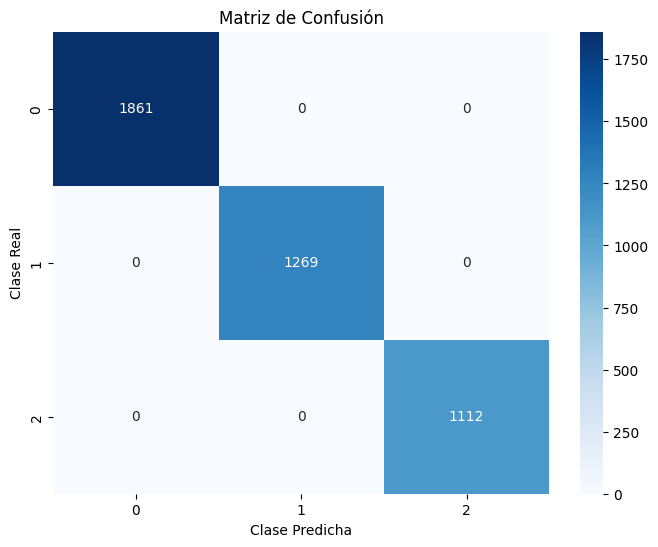

In [323]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [324]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.885956644674835
Precision:  0.8894289708982898
Precision per class: [0.8552381  0.87037037 0.96240602]
Recall:  0.885956644674835
Recall per class: [0.96767241 0.7807309  0.86486486]
F1 Score:  0.8847598202044101
F1-score for the class 0: 0.9079878665318504
F1-score for the class 1: 0.8231173380035026
F1-score for the class 2: 0.9110320284697508
jaccard: 1.0
Confusion Matrix: 
[[449  10   5]
 [ 61 235   5]
 [ 15  25 256]]


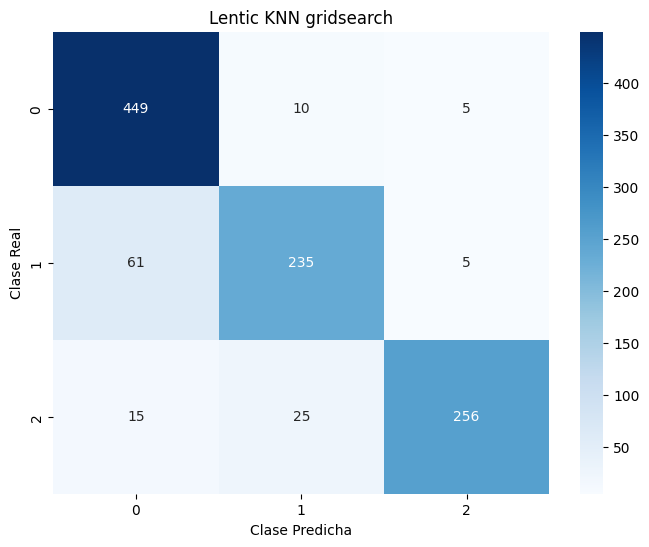

In [325]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic KNN gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [326]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8333333333333334
Precision:  0.8574334898278559
Precision per class: [0.73333333 0.94366197 0.5       ]
Recall:  0.8333333333333334
Recall per class: [0.84615385 0.82716049 0.83333333]
F1 Score:  0.8396885069817399
F1-score for the class 0: 0.7857142857142857
F1-score for the class 1: 0.881578947368421
F1-score for the class 2: 0.625
jaccard: 0.7286478227654698
Confusion Matrix: 
[[33  4  2]
 [11 67  3]
 [ 1  0  5]]


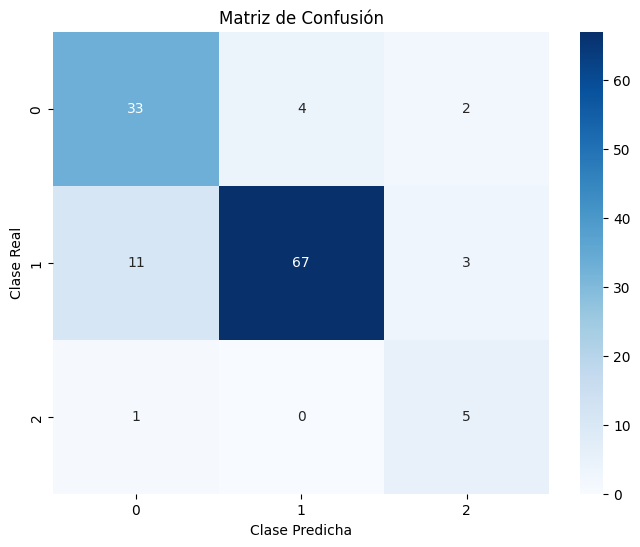

In [327]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####DT

In [328]:
# Define a dictionary of hyperparameters for tuning a DT model
parameters = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división de nodos
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en una hoja
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_dt = DecisionTreeClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_dt, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_dt.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, Accuracy: 0.9962299717247879, Best score (cv): 0.9985857390492701
Best model: DecisionTreeClassifier()
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9985857390492701


######Metrics

 Evaluate the model on the training set

In [329]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[1861    0    0]
 [   0 1269    0]
 [   0    0 1112]]


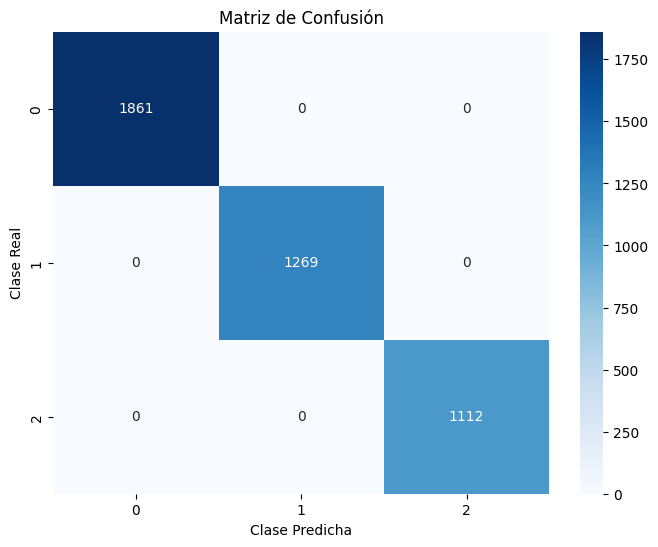

In [330]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [331]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9962299717247879
Precision:  0.9962621941886786
Precision per class: [0.99145299 1.         1.        ]
Recall:  0.9962299717247879
Recall per class: [1.         0.98671096 1.        ]
F1 Score:  0.9962254531240017
F1-score for the class 0: 0.9957081545064378
F1-score for the class 1: 0.9933110367892977
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[464   0   0]
 [  4 297   0]
 [  0   0 296]]


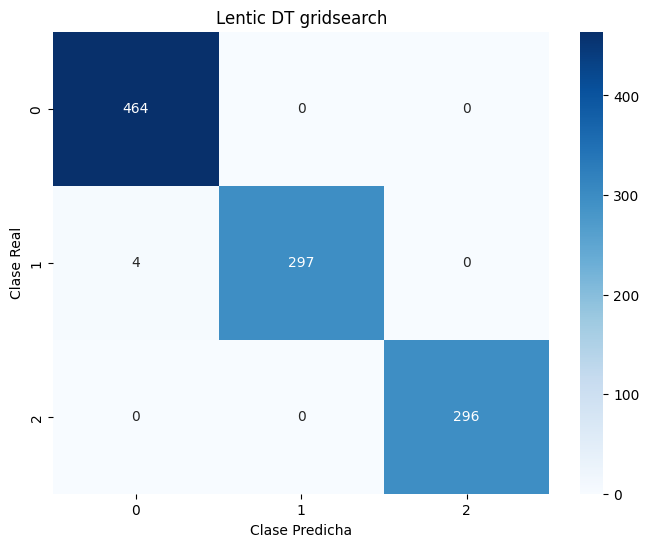

In [332]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic DT gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [333]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[39  0  0]
 [ 0 81  0]
 [ 0  0  6]]


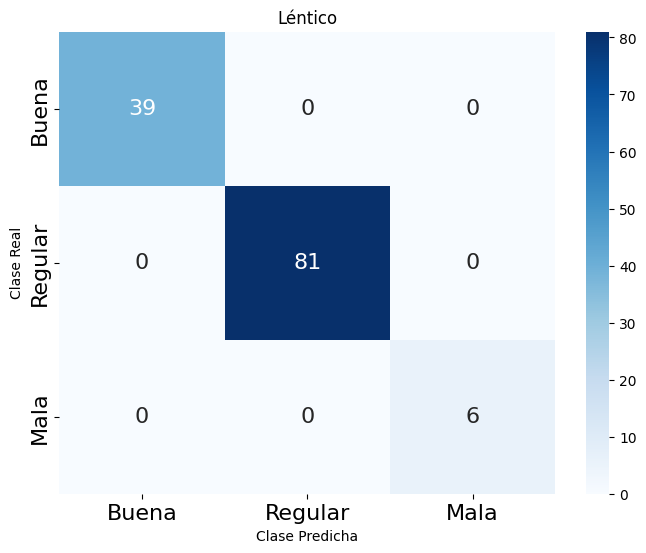

In [334]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Léntico')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####MLR

In [335]:
# Define a dictionary of hyperparameters for tuning a MLR model
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Método de optimización
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_mlr = LogisticRegression(max_iter=1000)  # Usamos max_iter para evitar advertencias

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_mlr, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_mlr.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best params: {'C': 100, 'solver': 'lbfgs'}, Accuracy: 0.8897266729500471, Best score (cv): 0.8962789185945729
Best model: LogisticRegression(C=100, max_iter=1000)
Best params: {'C': 100, 'solver': 'lbfgs'}
Best score: 0.8962789185945729


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


######Metrics

Evaluate the model on the training set

In [336]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8974540311173974
Precision:  0.8970743392499935
Precision per class: [0.87041817 0.85618167 0.98835125]
Recall:  0.8974540311173974
Recall per class: [0.90596454 0.80220646 0.99190647]
F1 Score:  0.8968445591919874
F1-score for the class 0: 0.8878357030015798
F1-score for the class 1: 0.8283157038242474
F1-score for the class 2: 0.9901256732495511
jaccard: 0.8187163043685322
Confusion Matrix: 
[[1686  169    6]
 [ 244 1018    7]
 [   7    2 1103]]


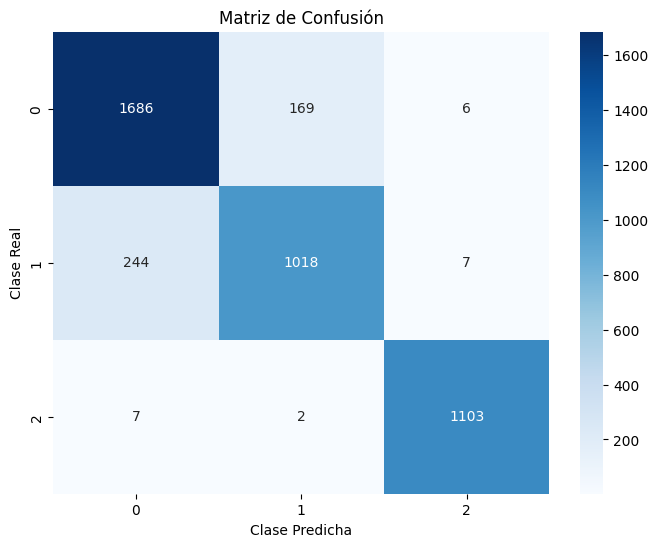

In [337]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [338]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8897266729500471
Precision:  0.8908324579981917
Precision per class: [0.84210526 0.8685259  0.98989899]
Recall:  0.8897266729500471
Recall per class: [0.93103448 0.72425249 0.99324324]
F1 Score:  0.8874498276880434
F1-score for the class 0: 0.8843398157625384
F1-score for the class 1: 0.7898550724637681
F1-score for the class 2: 0.9915682967959528
jaccard: 0.8187163043685322
Confusion Matrix: 
[[432  31   1]
 [ 81 218   2]
 [  0   2 294]]


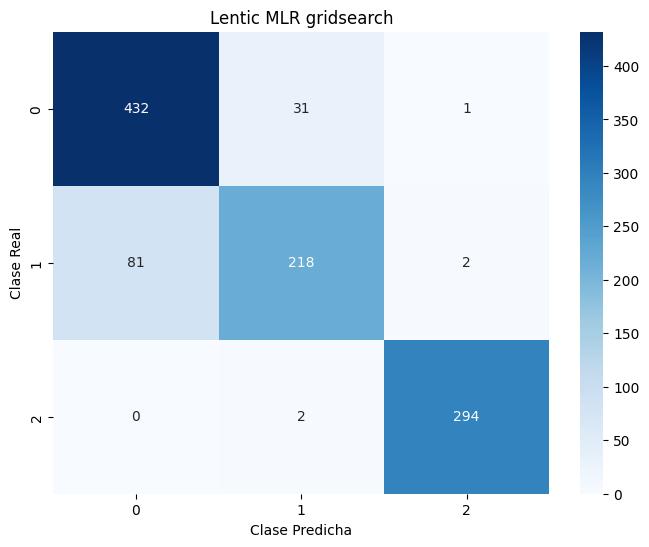

In [339]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic MLR gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [340]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8492063492063492
Precision:  0.8469967532467533
Precision per class: [0.8125     0.85227273 1.        ]
Recall:  0.8492063492063492
Recall per class: [0.66666667 0.92592593 1.        ]
F1 Score:  0.844895804809131
F1-score for the class 0: 0.7323943661971831
F1-score for the class 1: 0.8875739644970414
F1-score for the class 2: 1.0
jaccard: 0.7393729595857255
Confusion Matrix: 
[[26 13  0]
 [ 6 75  0]
 [ 0  0  6]]


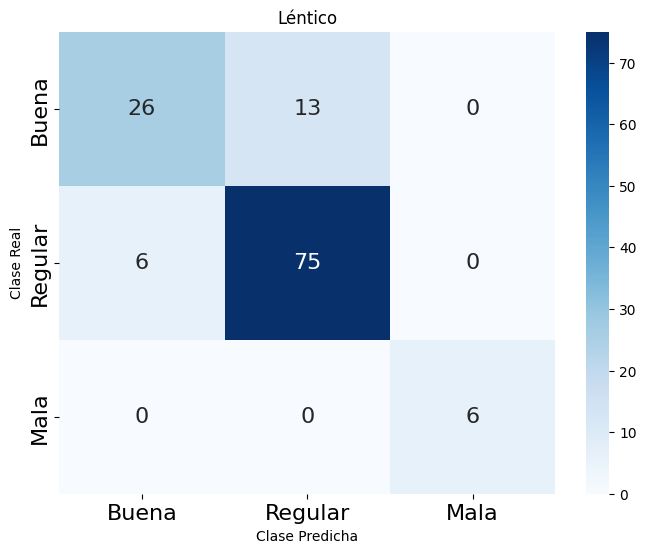

In [341]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Léntico')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


####Balanced classes

#####Separation of data into training and test sets

Apply random subsampling

In [342]:
print('Before class balancing: ', Counter(y_train_lentic_num))
print("")
rus = RandomUnderSampler(random_state=42)
X_train_lentic_num, y_train_lentic_num = rus.fit_resample(X_train_lentic_num, y_train_lentic_num)
print('After the balancing y:', Counter(y_train_lentic_num))
print("")
print('After the balancing X:', Counter(X_train_lentic_num))

Before class balancing:  Counter({0: 2325, 1: 1570, 2: 1408})

After the balancing y: Counter({0: 1408, 1: 1408, 2: 1408})

After the balancing X: Counter({'SST': 1, 'CF': 1, 'E_COLI': 1, 'ODs%': 1, 'ODm%': 1, 'ODf%': 1, 'DBO5': 1, 'DQO': 1, 'TOX_D48s': 1, 'TOX_D48f': 1, 'TOX_F15s': 1, 'TOX_F15f': 1})


In [343]:
# Guardar el conjunto de entrenamiento en un archivo Excel
#X_train_b_coa.to_excel("train_data_b_coa.xlsx", index=False)
#y_train_b_coa.to_excel("train_labels_data_b_coa.xlsx", index=False)

# Guardar el conjunto de prueba en un archivo Excel
#X_test_b_coa.to_excel("test_data_b_coa.xlsx", index=False)
#y_test_b_coa.to_excel("test_labels_data_b_coa.xlsx", index=False)

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X_train_lentic_num, y_train_lentic_num, test_size= 0.2, random_state=42)

In [345]:
# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [346]:
X_train.shape, X_test.shape

((3379, 12), (845, 12))

#####XGBOOST

In [347]:
# Define a dictionary of hyperparameters for tuning a XGBoost model
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_xgb = XGBClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_xgb, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_xgb.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}, Accuracy: 0.9940828402366864, Best score (cv): 0.9937861056322594
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimato

######Metrics

 Evaluate the model on the training set

In [348]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.999408108907961
Precision:  0.999408108907961
Precision per class: [0.99908842 1.         0.99913119]
Recall:  0.999408108907961
Recall per class: [0.99908842 1.         0.99913119]
F1 Score:  0.999408108907961
F1-score for the class 0: 0.9990884229717412
F1-score for the class 1: 1.0
F1-score for the class 2: 0.9991311902693311
jaccard: 0.9988172706731979
Confusion Matrix: 
[[1096    0    1]
 [   0 1131    0]
 [   1    0 1150]]


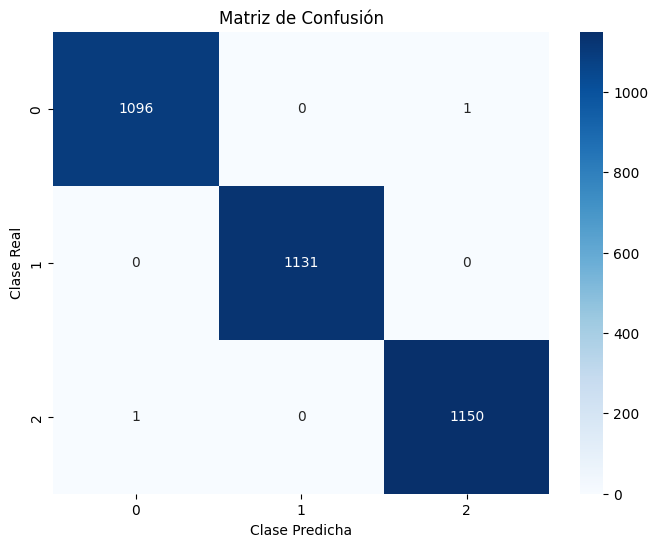

In [349]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [350]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9940828402366864
Precision:  0.9941013503971551
Precision per class: [0.99675325 0.98924731 0.99612403]
Recall:  0.9940828402366864
Recall per class: [0.98713826 0.99638989 1.        ]
F1 Score:  0.9940781642624271
F1-score for the class 0: 0.9919224555735057
F1-score for the class 1: 0.9928057553956835
F1-score for the class 2: 0.9980582524271845
jaccard: 0.9988172706731979
Confusion Matrix: 
[[307   3   1]
 [  1 276   0]
 [  0   0 257]]


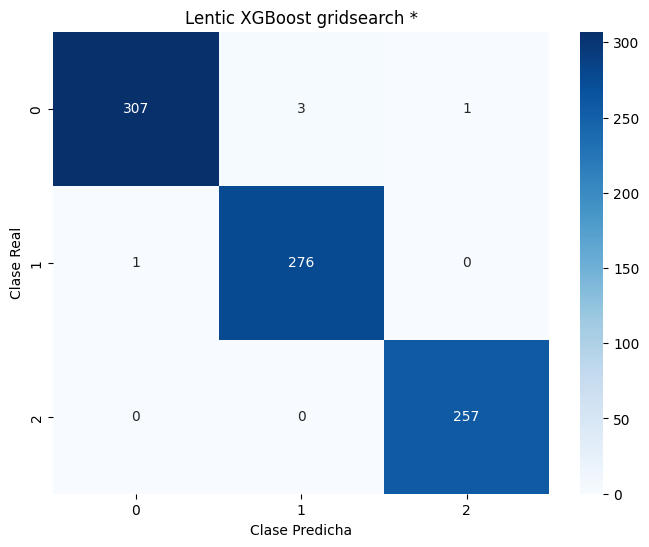

In [351]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic XGBoost gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [352]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[39  0  0]
 [ 0 81  0]
 [ 0  0  6]]


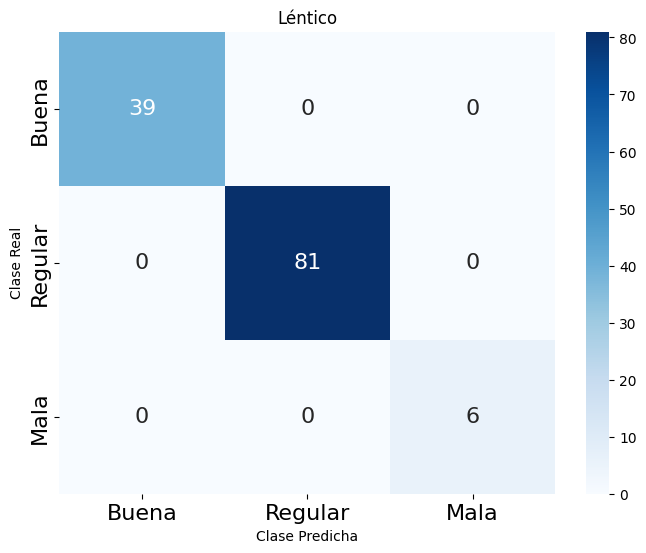

In [353]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Léntico')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####SVM

In [354]:
# Define a dictionary of hyperparameters for tuning a SVM model
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_svm = SVC()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_svm, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_svm.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, Accuracy: 0.9550295857988166, Best score (cv): 0.9532426035502958
Best model: SVC(C=10, gamma=0.1)
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.9532426035502958


######Metrics

 Evaluate the model on the training set

In [355]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9680378810298905
Precision:  0.9679269823080656
Precision per class: [0.96292864 0.95667551 0.98374679]
Recall:  0.9680378810298905
Recall per class: [0.94712853 0.95667551 0.99913119]
F1 Score:  0.9679408864529575
F1-score for the class 0: 0.9549632352941176
F1-score for the class 1: 0.9566755083996463
F1-score for the class 2: 0.9913793103448276
jaccard: 0.9383965513925419
Confusion Matrix: 
[[1039   48   10]
 [  40 1082    9]
 [   0    1 1150]]


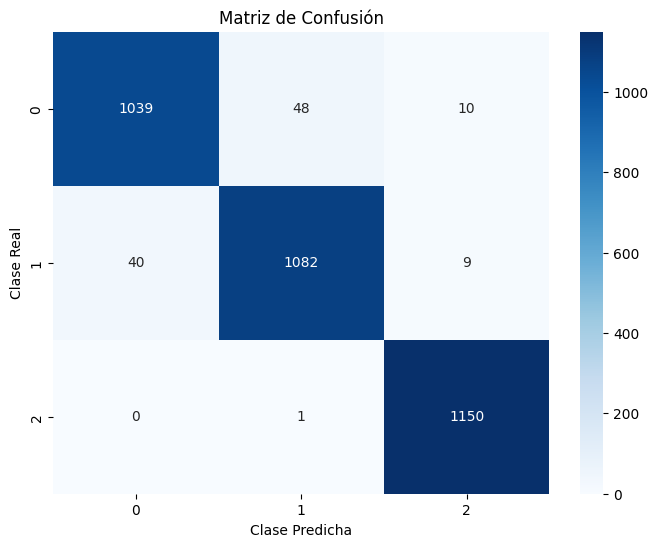

In [356]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [357]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9550295857988166
Precision:  0.9549138326061404
Precision per class: [0.95498392 0.94814815 0.96212121]
Recall:  0.9550295857988166
Recall per class: [0.95498392 0.92418773 0.98832685]
F1 Score:  0.9548679091621806
F1-score for the class 0: 0.954983922829582
F1-score for the class 1: 0.9360146252285192
F1-score for the class 2: 0.9750479846449136
jaccard: 0.9383965513925419
Confusion Matrix: 
[[297  11   3]
 [ 14 256   7]
 [  0   3 254]]


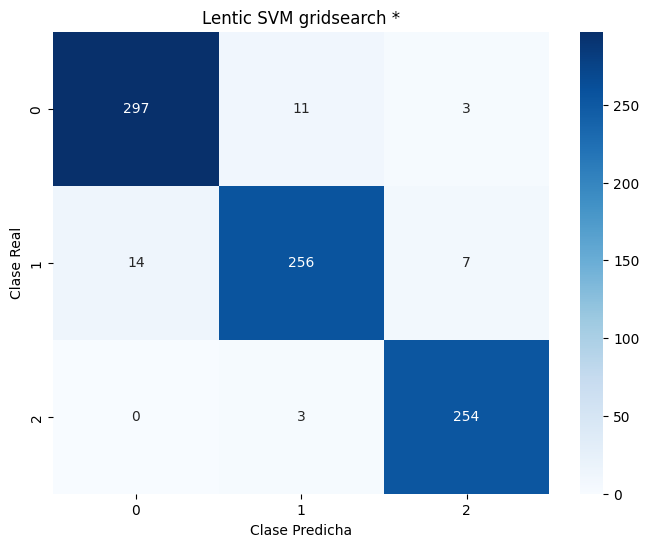

In [358]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic SVM gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [359]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8968253968253969
Precision:  0.8965986394557823
Precision per class: [0.88571429 0.9047619  0.85714286]
Recall:  0.8968253968253969
Recall per class: [0.79487179 0.9382716  1.        ]
F1 Score:  0.8954945954945955
F1-score for the class 0: 0.8378378378378378
F1-score for the class 1: 0.9212121212121213
F1-score for the class 2: 0.9230769230769231
jaccard: 0.8129180598291055
Confusion Matrix: 
[[31  8  0]
 [ 4 76  1]
 [ 0  0  6]]


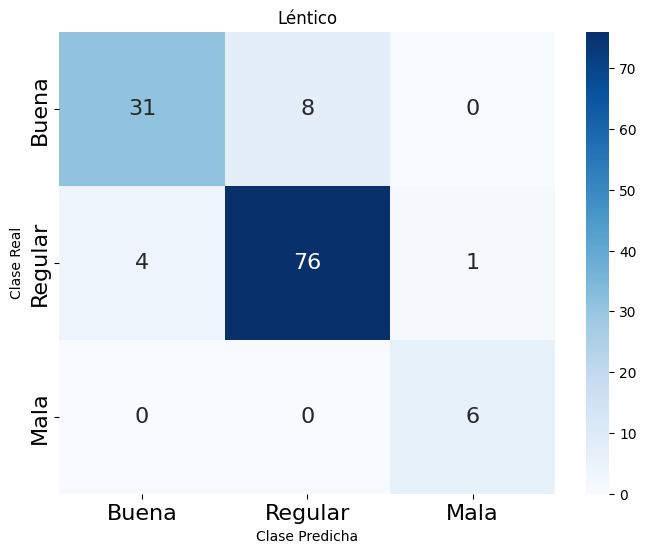

In [360]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Léntico')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####KNN

In [361]:
# Define a dictionary of hyperparameters for tuning a KNN model
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'p': [1, 2]  # Parámetro para la distancia (1 para la distancia de Manhattan, 2 para la Euclidiana)
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_knn = KNeighborsClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_knn, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_knn.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}, Accuracy: 0.8923076923076924, Best score (cv): 0.8928669734823581
Best model: KNeighborsClassifier(n_neighbors=3, p=1)
Best params: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best score: 0.8928669734823581


######Metrics

 Evaluate the model on the training set

In [362]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9476176383545427
Precision:  0.9490174837654426
Precision per class: [0.9057725  0.96387833 0.97563098]
Recall:  0.9476176383545427
Recall per class: [0.97265269 0.89655172 0.97393571]
F1 Score:  0.9475230144534615
F1-score for the class 0: 0.9380219780219781
F1-score for the class 1: 0.9289967934035731
F1-score for the class 2: 0.9747826086956521
jaccard: 0.9009683512206912
Confusion Matrix: 
[[1067   17   13]
 [ 102 1014   15]
 [   9   21 1121]]


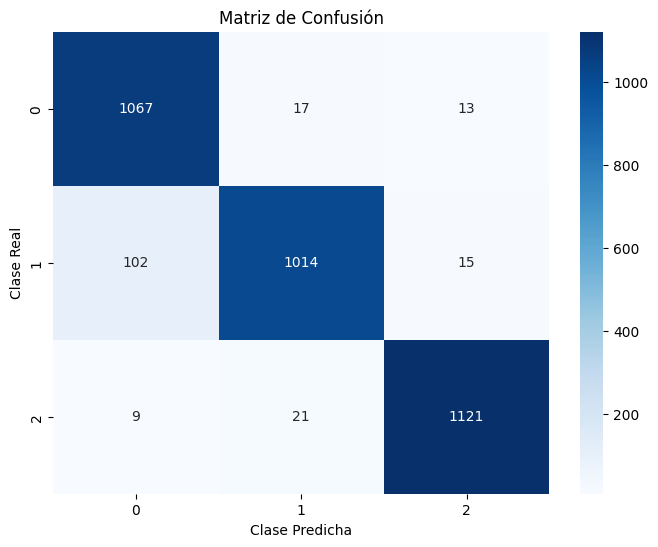

In [363]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [364]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8923076923076924
Precision:  0.893390621349437
Precision per class: [0.86470588 0.88582677 0.93625498]
Recall:  0.8923076923076924
Recall per class: [0.94533762 0.81227437 0.91439689]
F1 Score:  0.8916267207923041
F1-score for the class 0: 0.9032258064516129
F1-score for the class 1: 0.847457627118644
F1-score for the class 2: 0.9251968503937008
jaccard: 0.9009683512206912
Confusion Matrix: 
[[294  12   5]
 [ 41 225  11]
 [  5  17 235]]


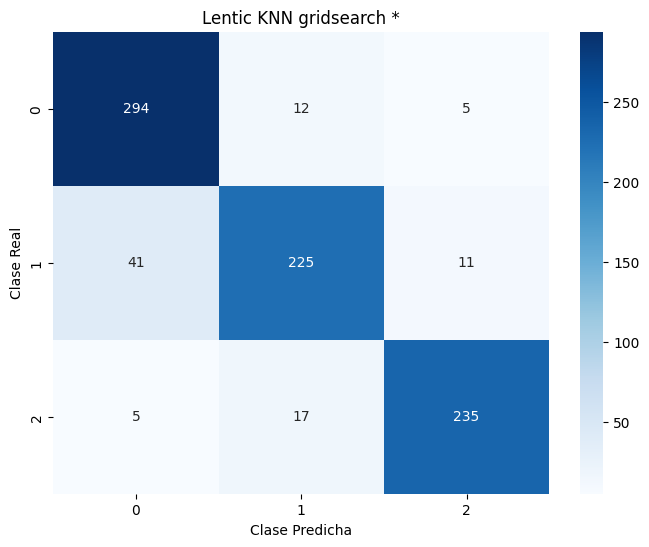

In [365]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic KNN gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [366]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8174603174603174
Precision:  0.8551978537894032
Precision per class: [0.8        0.91549296 0.4       ]
Recall:  0.8174603174603174
Recall per class: [0.82051282 0.80246914 1.        ]
F1 Score:  0.8277763803722689
F1-score for the class 0: 0.810126582278481
F1-score for the class 1: 0.8552631578947368
F1-score for the class 2: 0.5714285714285714
jaccard: 0.7100828005450163
Confusion Matrix: 
[[32  6  1]
 [ 8 65  8]
 [ 0  0  6]]


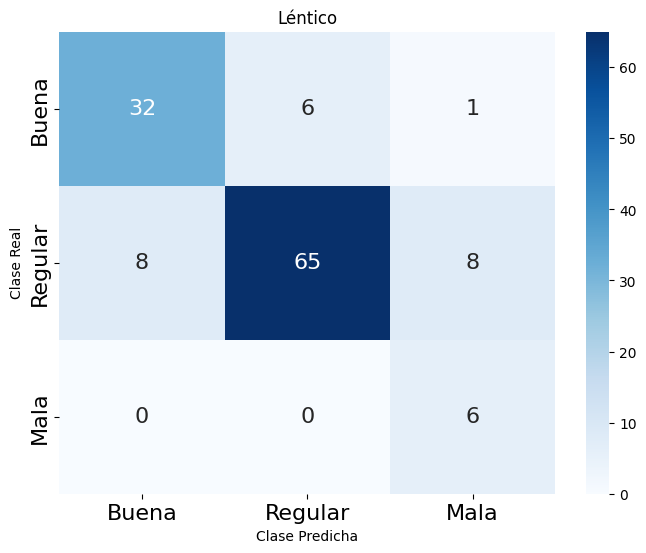

In [367]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Léntico')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####DT

In [368]:
# Define a dictionary of hyperparameters for tuning a DT model
parameters = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división de nodos
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en una hoja
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_dt = DecisionTreeClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_dt, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_dt.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, Accuracy: 0.9976331360946745, Best score (cv): 0.9973372781065087
Best model: DecisionTreeClassifier(criterion='entropy')
Best params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9973372781065087


######Metrics

 Evaluate the model on the training set

In [369]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[1097    0    0]
 [   0 1131    0]
 [   0    0 1151]]


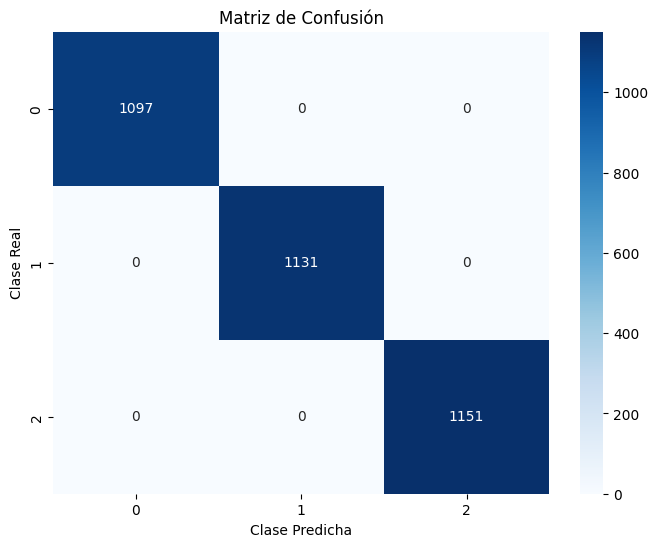

In [370]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [371]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9976331360946745
Precision:  0.9976331360946745
Precision per class: [0.99678457 0.99638989 1.        ]
Recall:  0.9976331360946745
Recall per class: [0.99678457 0.99638989 1.        ]
F1 Score:  0.9976331360946745
F1-score for the class 0: 0.9967845659163987
F1-score for the class 1: 0.9963898916967509
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[310   1   0]
 [  1 276   0]
 [  0   0 257]]


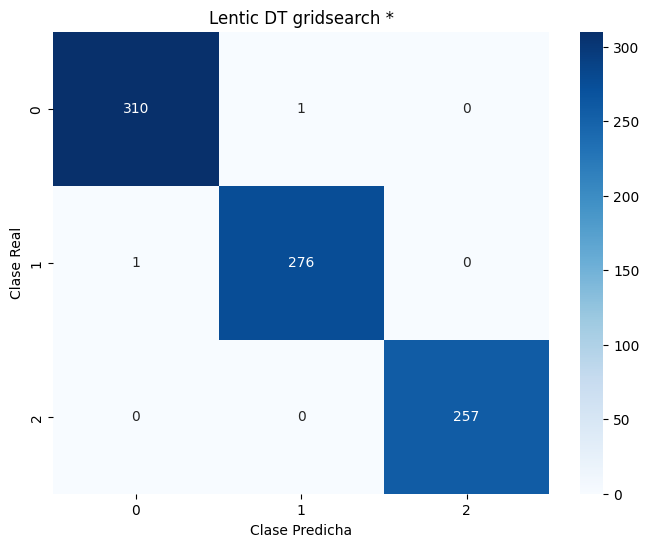

In [372]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic DT gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [373]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[39  0  0]
 [ 0 81  0]
 [ 0  0  6]]


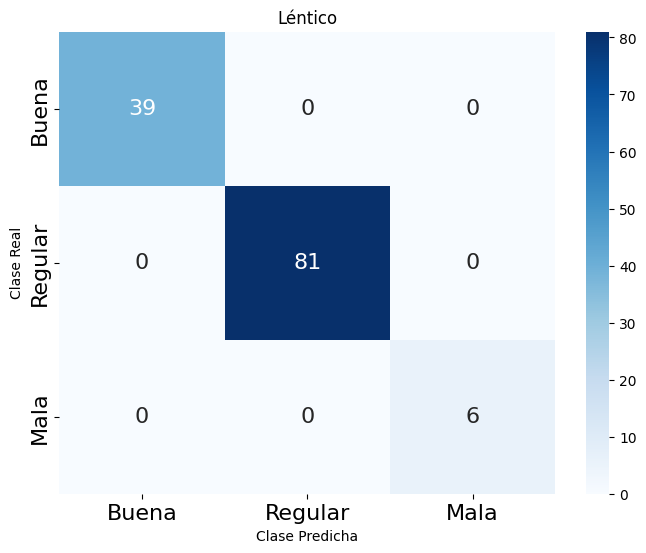

In [374]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Léntico')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####MLR

In [375]:
# Define a dictionary of hyperparameters for tuning a MLR model
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Método de optimización
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_lentic_mlr = LogisticRegression(max_iter=1000)  # Usamos max_iter para evitar advertencias

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_lentic_mlr, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_lentic_mlr.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best params: {'C': 100, 'solver': 'newton-cg'}, Accuracy: 0.9100591715976332, Best score (cv): 0.889913214990138
Best model: LogisticRegression(C=100, max_iter=1000, solver='newton-cg')
Best params: {'C': 100, 'solver': 'newton-cg'}
Best score: 0.889913214990138


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


######Metrics

 Evaluate the model on the training set

In [376]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8940514945250074
Precision:  0.8938065135811026
Precision per class: [0.83647799 0.85275519 0.98878343]
Recall:  0.8940514945250074
Recall per class: [0.84867821 0.83465959 0.99565595]
F1 Score:  0.8938781360564484
F1-score for the class 0: 0.8425339366515837
F1-score for the class 1: 0.8436103663985701
F1-score for the class 2: 0.9922077922077922
jaccard: 0.8158653646928239
Confusion Matrix: 
[[ 931  162    4]
 [ 178  944    9]
 [   4    1 1146]]


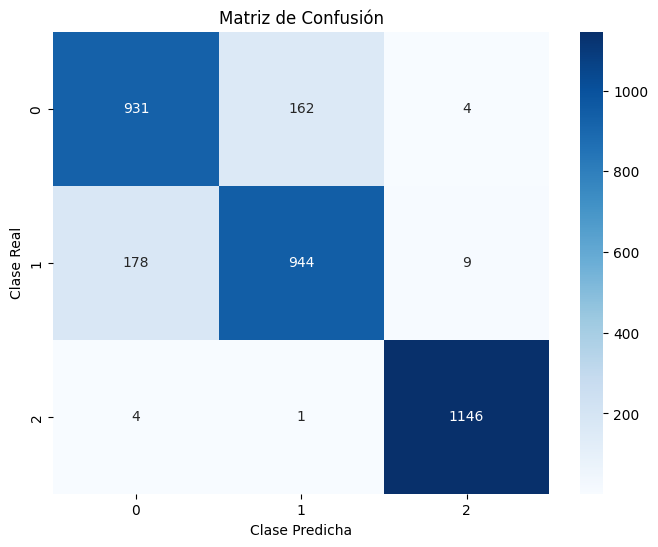

In [377]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [378]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9100591715976332
Precision:  0.9098171126776287
Precision per class: [0.87421384 0.87686567 0.98841699]
Recall:  0.9100591715976332
Recall per class: [0.89389068 0.84837545 0.99610895]
F1 Score:  0.9098161966874599
F1-score for the class 0: 0.8839427662957074
F1-score for the class 1: 0.8623853211009175
F1-score for the class 2: 0.9922480620155039
jaccard: 0.8158653646928239
Confusion Matrix: 
[[278  32   1]
 [ 40 235   2]
 [  0   1 256]]


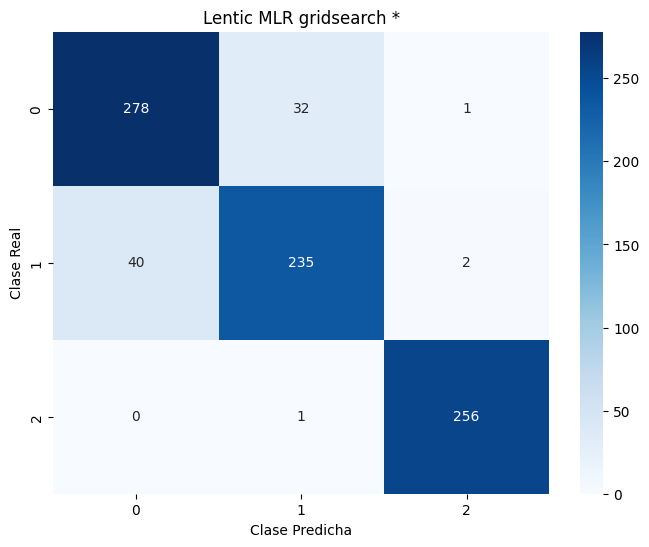

In [379]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Lentic MLR gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [380]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_lentic_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_lentic_num, y_pred)
precision = precision_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_lentic_num, y_pred, average=None)
recall = recall_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_lentic_num, y_pred, average=None)
f1 = f1_score(y_val_lentic_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_lentic_num, y_pred, average=None)
jaccard = jaccard_score(y_val_lentic_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_lentic_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8809523809523809
Precision:  0.8870526471458148
Precision per class: [0.92857143 0.85869565 1.        ]
Recall:  0.8809523809523809
Recall per class: [0.66666667 0.97530864 1.        ]
F1 Score:  0.8749645661042434
F1-score for the class 0: 0.7761194029850746
F1-score for the class 1: 0.9132947976878613
F1-score for the class 2: 1.0
jaccard: 0.7841759952553934
Confusion Matrix: 
[[26 13  0]
 [ 2 79  0]
 [ 0  0  6]]


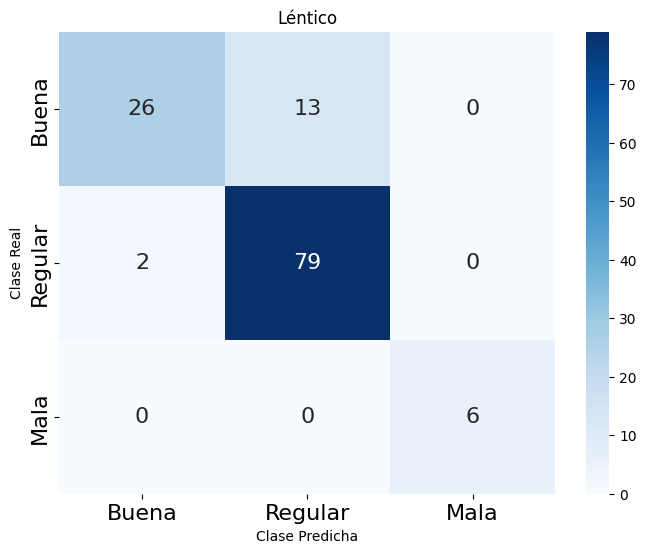

In [381]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_lentic_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Léntico')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####Empaquetado del escalador

In [382]:
# Save the scaler used for preprocessing to a file
#with open('scaler_coa.pkl', 'wb') as scaler_file:
#    pickle.dump(scaler_coa, scaler_file)